Dataset: https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link

# **Goal:**

* predicting the likelihood of a patient developing lung cancer
* identifying risk factors for lung cancer
* determining the most effective treatment for a patient with lung cancer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('lung_cancer.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFeature Names:")
print(df.columns.tolist())

Dataset Shape: (1000, 26)

Feature Names:
['index', 'Patient Id', 'Age', 'Gender', 'Air Pollution', 'Alcohol use', 'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk', 'chronic Lung Disease', 'Balanced Diet', 'Obesity', 'Smoking', 'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Shortness of Breath', 'Wheezing', 'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold', 'Dry Cough', 'Snoring', 'Level']


In [3]:
df.head()

,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


In [4]:
class LungCancerPredictor:
    def __init__(self, data_path):
        """Initialize the predictor with data"""
        self.df = pd.read_csv(data_path)
        self.df = self.df.drop('index', axis=1)  # Keep Patient Id
        self.prepare_data()

    def prepare_data(self):
        """Prepare data for cancer prediction analysis"""
        # Convert risk levels to numerical values
        le = LabelEncoder()
        self.df['Cancer_Risk'] = le.fit_transform(self.df['Level'])
        self.risk_level_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

        # Define features to use
        self.feature_names = [col for col in self.df.columns
                            if col not in ['Level', 'Cancer_Risk', 'Patient Id', 'index']]

        # Create feature categories
        self.feature_categories = {
            'Demographics': ['Age', 'Gender'],
            'Environmental': ['Air Pollution', 'Dust Allergy', 'OccuPational Hazards'],
            'Lifestyle': ['Alcohol use', 'Smoking', 'Passive Smoker', 'Balanced Diet', 'Obesity'],
            'Medical': ['Genetic Risk', 'chronic Lung Disease'],
            'Symptoms': [col for col in self.feature_names if col not in
                        ['Age', 'Gender', 'Air Pollution', 'Dust Allergy', 'OccuPational Hazards',
                         'Alcohol use', 'Smoking', 'Passive Smoker', 'Balanced Diet', 'Obesity',
                         'Genetic Risk', 'chronic Lung Disease']]
        }

        # Split features and target
        self.X = self.df[self.feature_names]
        self.y = self.df['Cancer_Risk']

        # Split and scale data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        # Train Random Forest model
        self.model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )
        self.model.fit(self.X_train_scaled, self.y_train)

    def predict_cancer_risk(self, patient_id):
        """Predict cancer risk for a specific patient with detailed analysis"""
        # Get patient data
        patient_data = self.df[self.df['Patient Id'] == patient_id].copy()
        if len(patient_data) == 0:
            raise ValueError(f"Patient ID {patient_id} not found")

        # Extract features
        patient_features = patient_data[self.feature_names]

        # Scale features
        patient_scaled = self.scaler.transform(patient_features)

        # Make predictions
        risk_pred = self.model.predict(patient_scaled)
        risk_probs = self.model.predict_proba(patient_scaled)

        # Get feature importance
        feature_imp = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Organize by category
        category_importance = {}
        for category, features in self.feature_categories.items():
            valid_features = [f for f in features if f in self.feature_names]
            if valid_features:
                category_importance[category] = feature_imp[
                    feature_imp['feature'].isin(valid_features)
                ]

        return {
            'patient_id': patient_id,
            'features': patient_features,
            'predicted_risk': risk_pred[0],
            'risk_probabilities': risk_probs[0],
            'feature_importance': feature_imp,
            'category_importance': category_importance
        }

    def visualize_risk_analysis(self, patient_id):
        """Create comprehensive visualizations for cancer risk analysis"""
        # Get analysis results
        analysis = self.predict_cancer_risk(patient_id)

        # Create figure
        fig = plt.figure(figsize=(20, 15))

        # 1. Risk Probability Distribution
        plt.subplot(3, 2, 1)
        risk_labels = ['Low', 'Medium', 'High']
        plt.bar(risk_labels, analysis['risk_probabilities'],
                color=['green', 'yellow', 'red'])
        plt.title(f'Cancer Risk Probabilities for Patient {patient_id}')
        plt.ylabel('Probability')

        # 2. Feature Importance
        plt.subplot(3, 2, 2)
        top_features = analysis['feature_importance'].head(10)
        sns.barplot(data=top_features, x='importance', y='feature')
        plt.title('Top 10 Important Features')

        # 3. Patient vs Population Comparison
        plt.subplot(3, 2, 3)
        patient_values = analysis['features'].iloc[0]
        population_means = self.X.mean()
        z_scores = (patient_values - population_means) / self.X.std()
        significant = z_scores[abs(z_scores) > 1]

        if len(significant) > 0:
            plt.bar(range(len(significant)), significant)
            plt.xticks(range(len(significant)), significant.index, rotation=45)
            plt.title('Significant Patient Characteristics\n(Standard Deviations from Mean)')

        # 4. Category Importance
        plt.subplot(3, 2, 4)
        category_means = {cat: df['importance'].mean()
                         for cat, df in analysis['category_importance'].items()}
        if category_means:
            plt.bar(category_means.keys(), category_means.values())
            plt.xticks(rotation=45)
            plt.title('Risk Factor Category Impact')

        # 5. Feature Correlations
        plt.subplot(3, 2, (5, 6))
        top_feature_names = analysis['feature_importance'].head(8)['feature']
        correlation_matrix = self.X[top_feature_names].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Feature Correlations')

        plt.tight_layout()
        plt.show()

        return analysis

    def evaluate_model_performance(self):
        """Evaluate model performance with detailed metrics"""
        # Basic prediction metrics
        y_pred = self.model.predict(self.X_test_scaled)
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred))

        # Cross-validation scores
        cv_scores = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=5)
        print("\nCross-validation scores:", cv_scores)
        print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

        # ROC curve for each class
        y_prob = self.model.predict_proba(self.X_test_scaled)
        n_classes = len(np.unique(self.y))

        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(self.y_test == i, y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Each Risk Class')
        plt.legend(loc="lower right")
        plt.show()



In [5]:
def print_treatment_summary(recommendations):
    """Print formatted treatment recommendations"""
    risk_analysis = recommendations['risk_analysis']
    protocol = recommendations['treatment_protocol']

    print("\nPatient Cancer Risk Analysis Summary")
    print("=" * 50)
    print(f"Patient ID: {risk_analysis['patient_id']}")
    print(f"Risk Level: {['Low', 'Medium', 'High'][risk_analysis['predicted_risk']]}")

    print("\nRisk Probabilities:")
    for level, prob in zip(['Low', 'Medium', 'High'], risk_analysis['risk_probabilities']):
        print(f"{level}: {prob:.2%}")

    print("\nRecommended Treatment Protocol")
    print("=" * 50)

    print("\nPrimary Interventions:")
    for intervention in protocol['primary_interventions']:
        print(f"- {intervention}")

    print("\nMonitoring Schedule:")
    print(f"Frequency: {protocol['monitoring_schedule']['frequency']}")
    print("Required Tests:")
    for test in protocol['monitoring_schedule']['tests']:
        print(f"- {test}")

    print("\nRisk Reduction Strategies:")
    for strategy in protocol['risk_reduction_strategies']:
        print(f"- {strategy}")

    print("\nSupport Services:")
    for service in protocol['support_services']:
        print(f"- {service}")

    print("\nKey Risk Factors:")
    for _, row in risk_analysis['feature_importance'].head(5).iterrows():
        print(f"- {row['feature']}: {row['importance']:.3f}")

Model Performance Evaluation:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        63

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Cross-validation scores: [1. 1. 1. 1. 1.]
Average CV score: 1.000 (+/- 0.000)


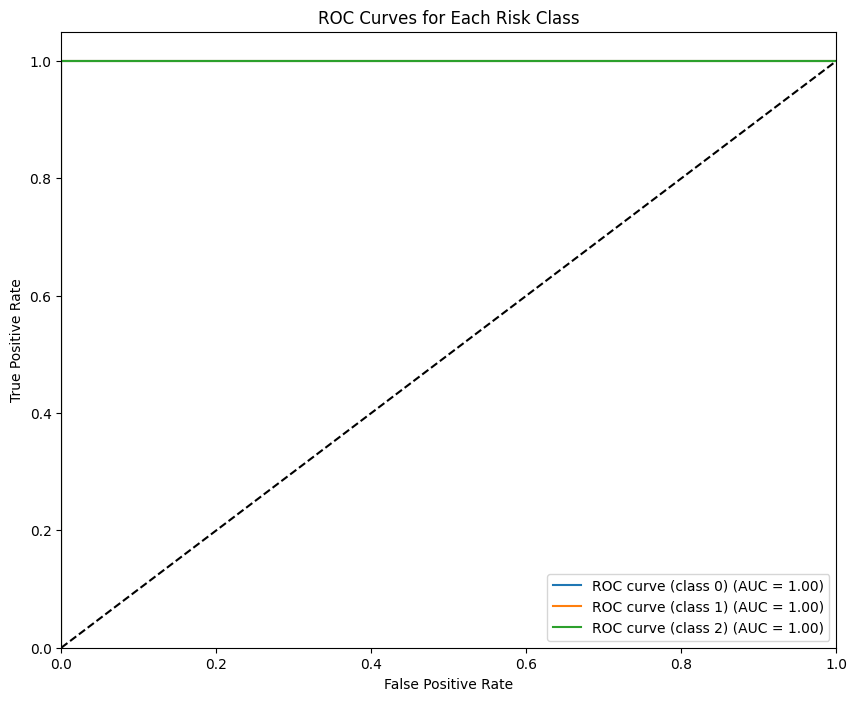

In [6]:
# Initialize the predictor with your data
predictor = LungCancerPredictor('lung_cancer.csv')

# Cell 4: Evaluate model performance
print("Model Performance Evaluation:")
print("=" * 50)

# Evaluate the model's performance
predictor.evaluate_model_performance()


Analyzing Patient P1


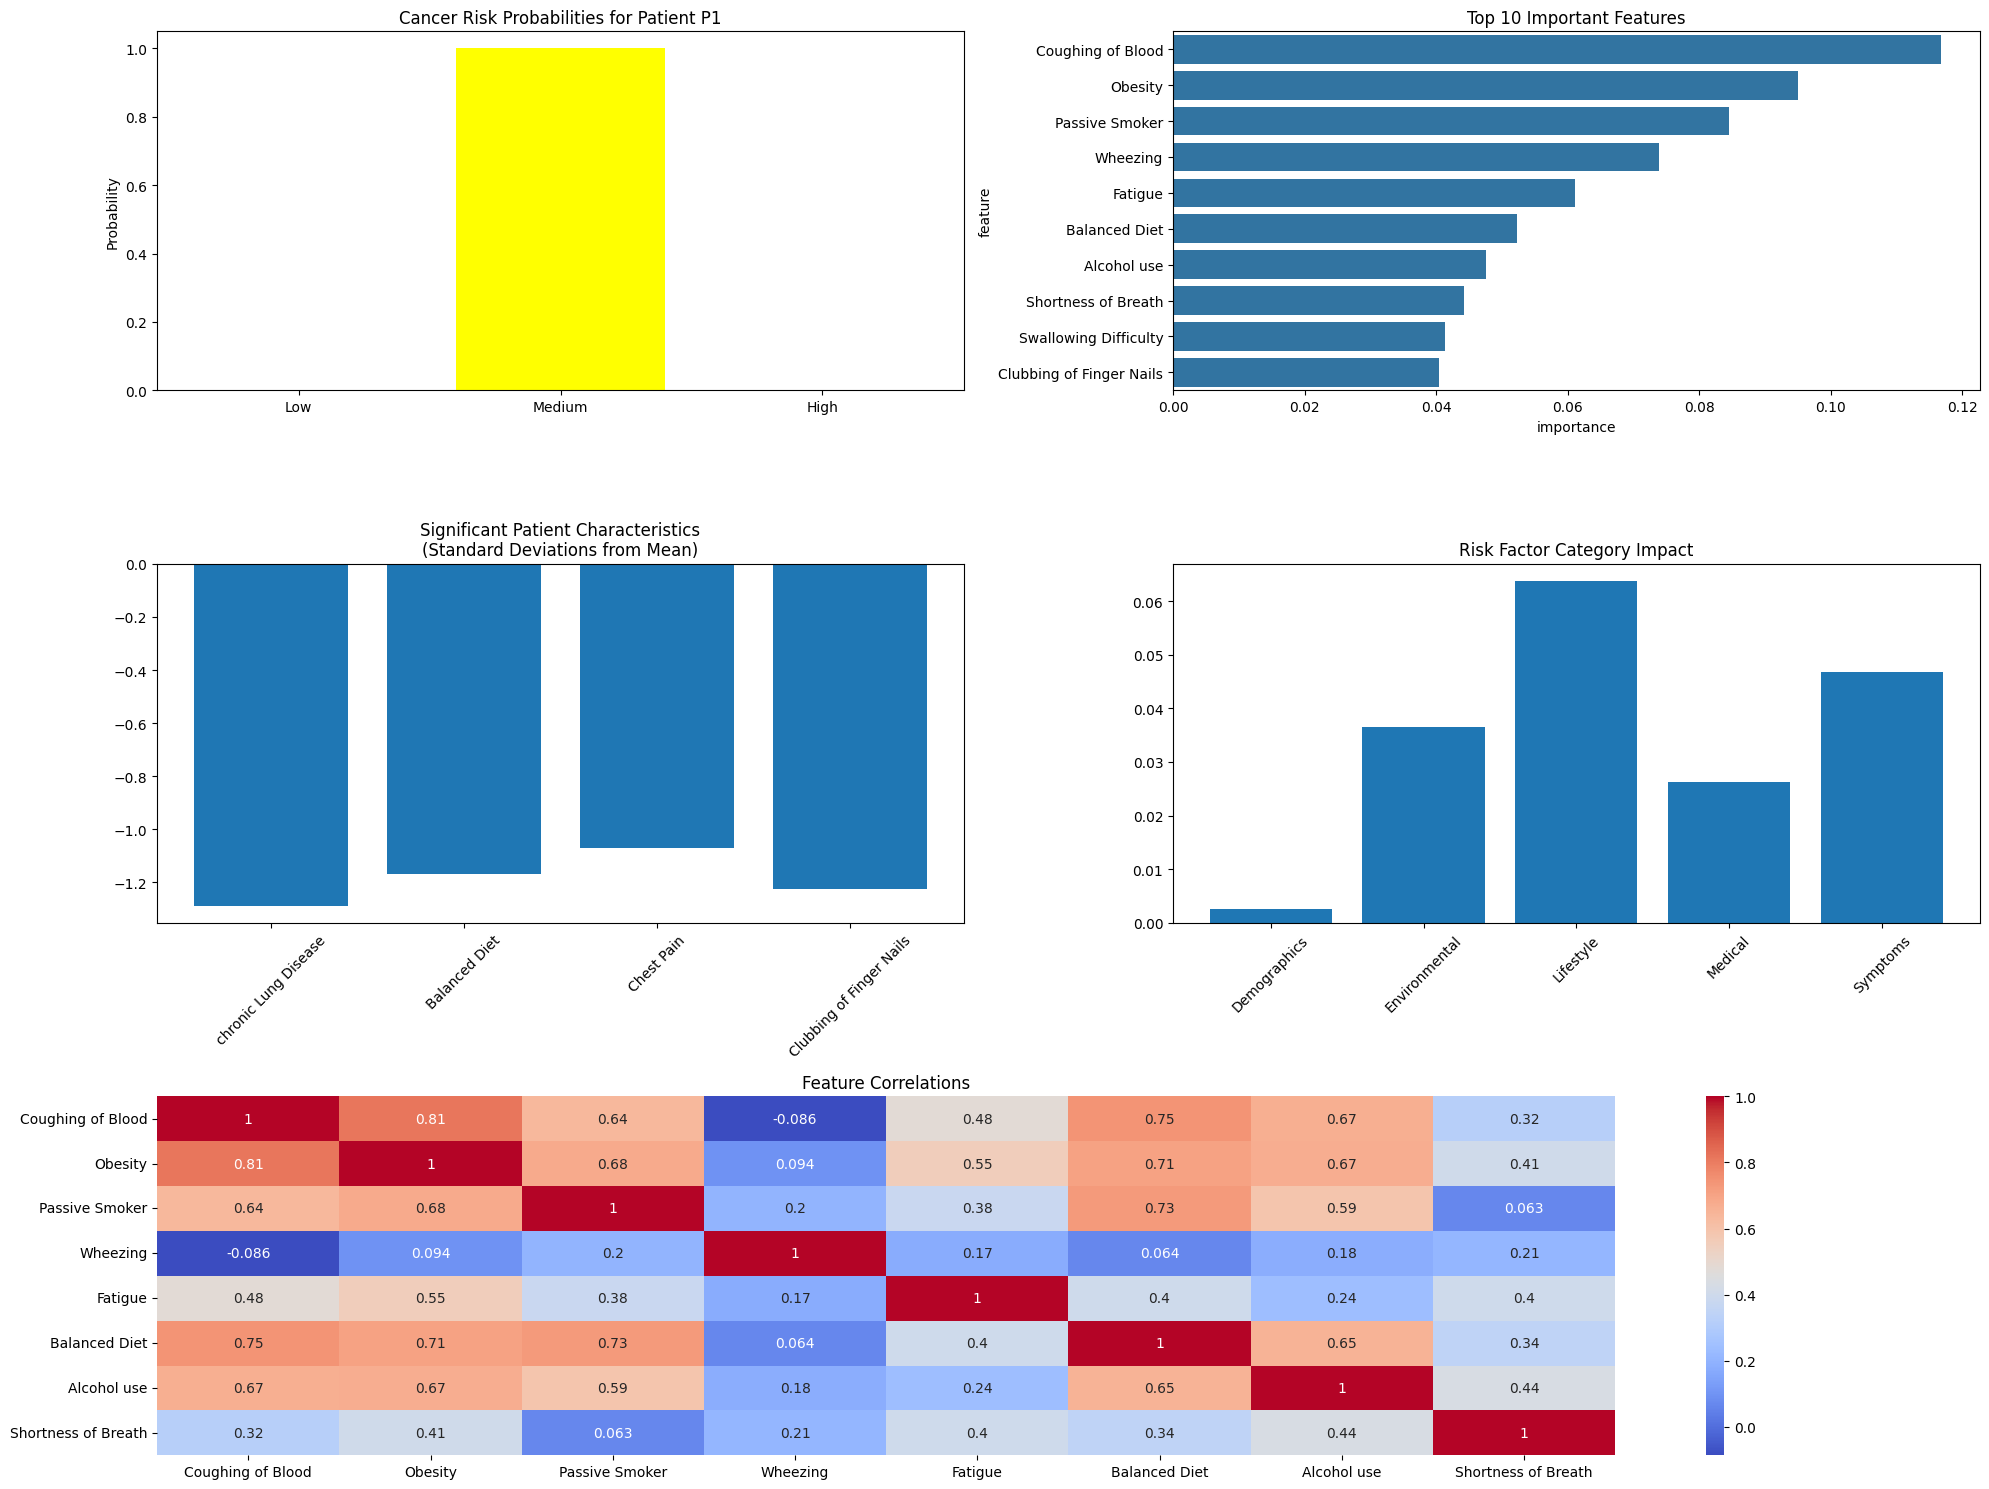


Risk Level Probabilities:
Low: 0.00%
Medium: 100.00%
High: 0.00%

Top 5 Risk Factors:
Coughing of Blood: 0.117
Obesity: 0.095
Passive Smoker: 0.085
Wheezing: 0.074
Fatigue: 0.061

Analyzing Patient P10


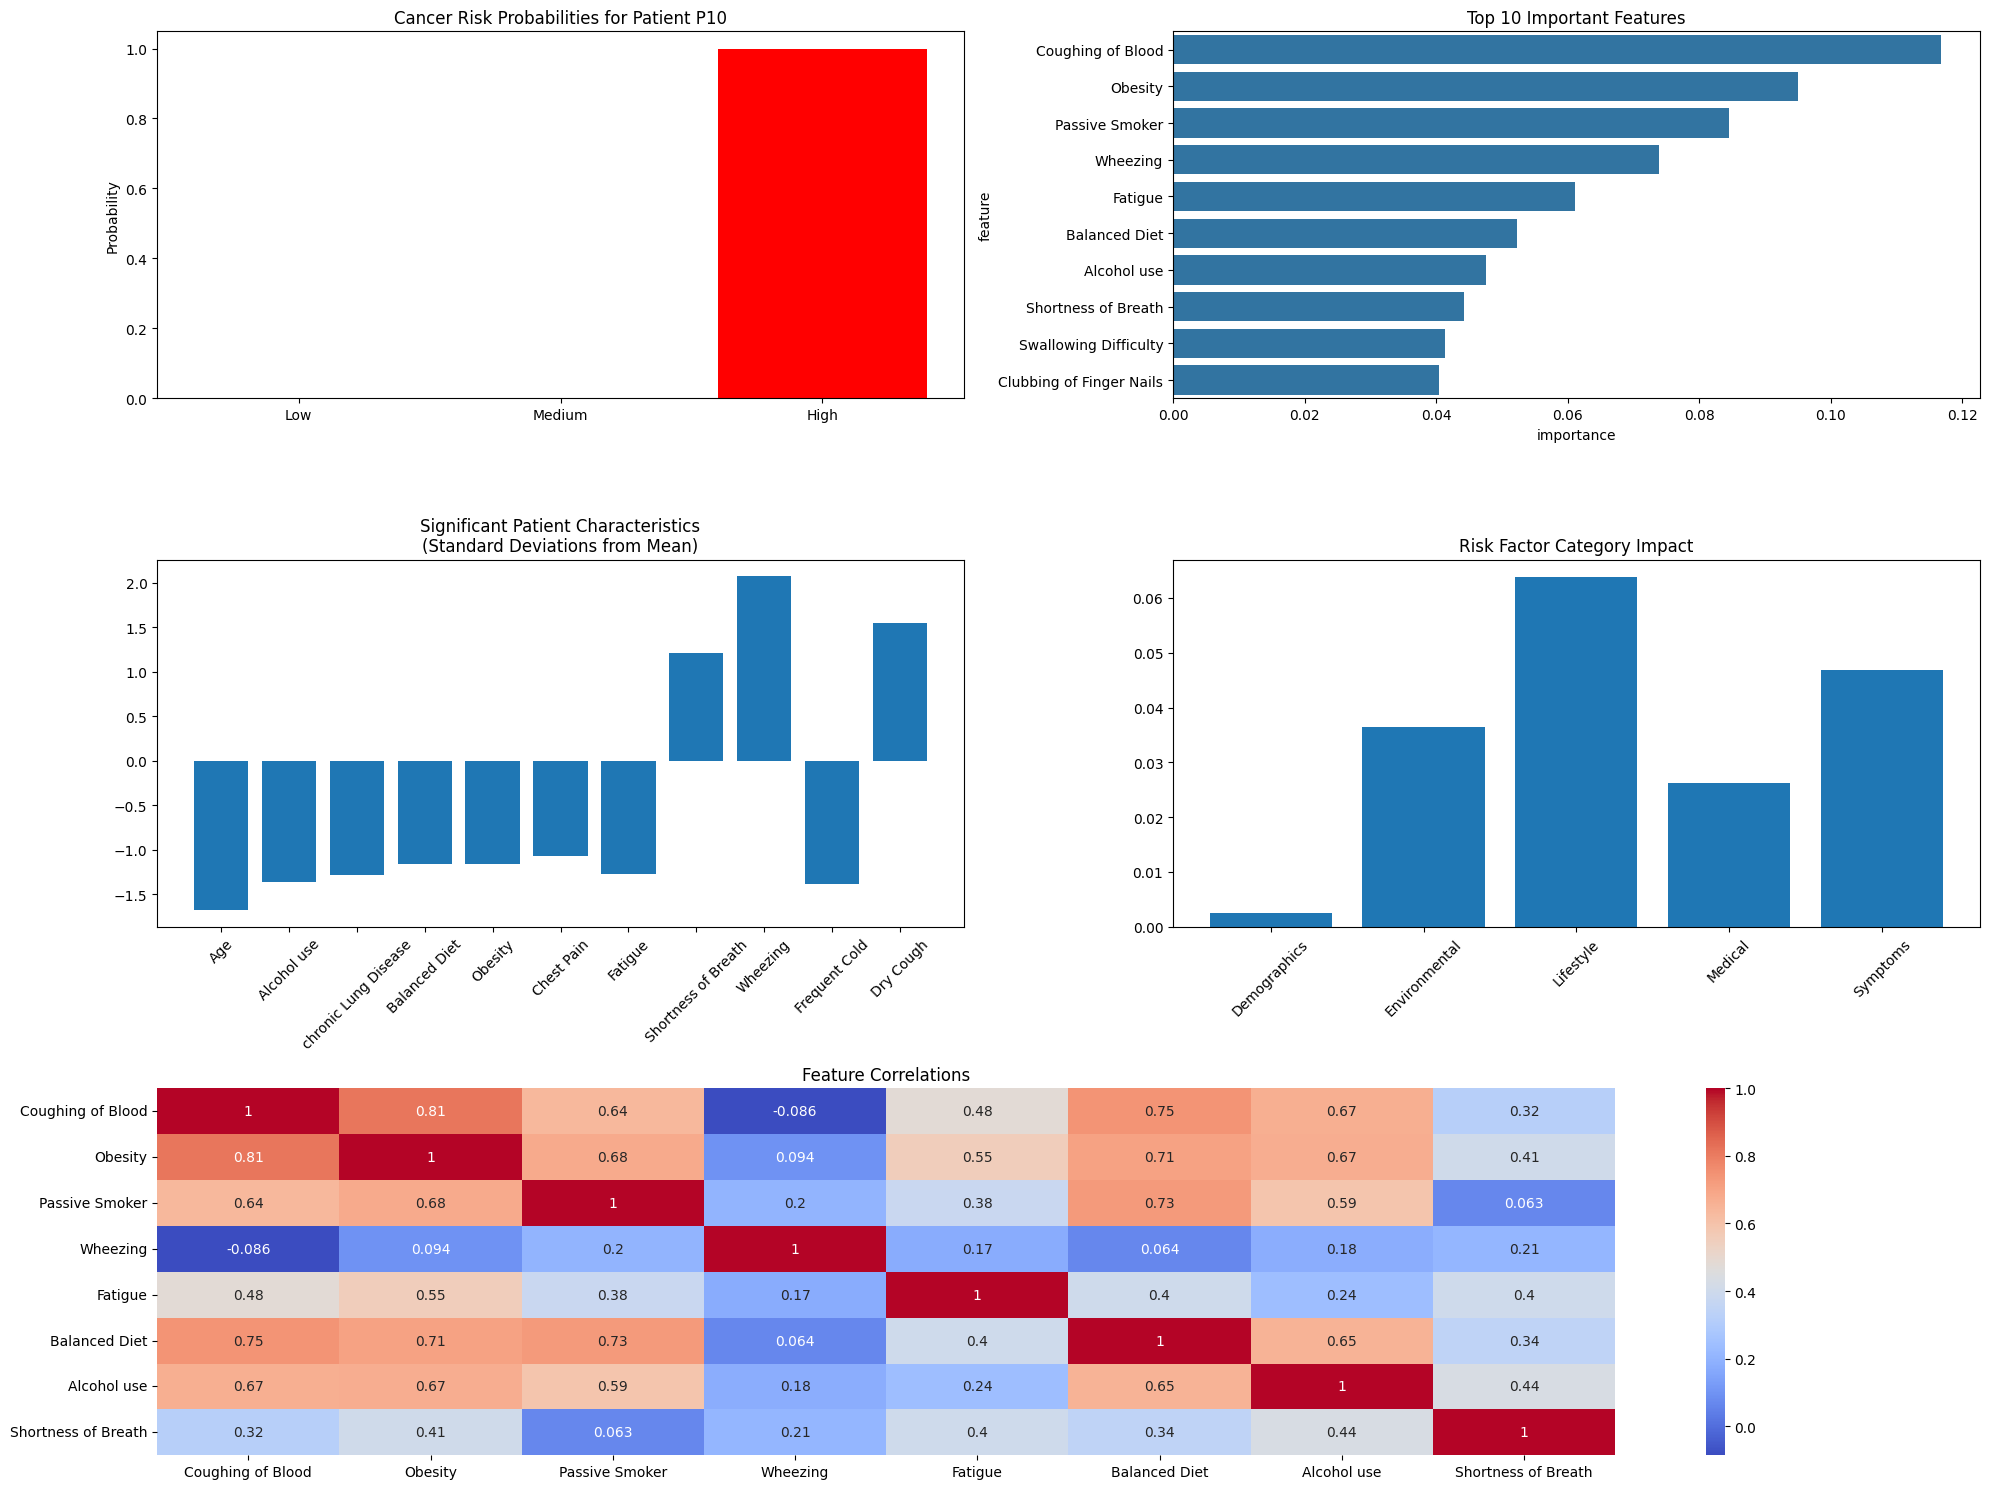


Risk Level Probabilities:
Low: 0.00%
Medium: 0.08%
High: 99.92%

Top 5 Risk Factors:
Coughing of Blood: 0.117
Obesity: 0.095
Passive Smoker: 0.085
Wheezing: 0.074
Fatigue: 0.061

Analyzing Patient P100


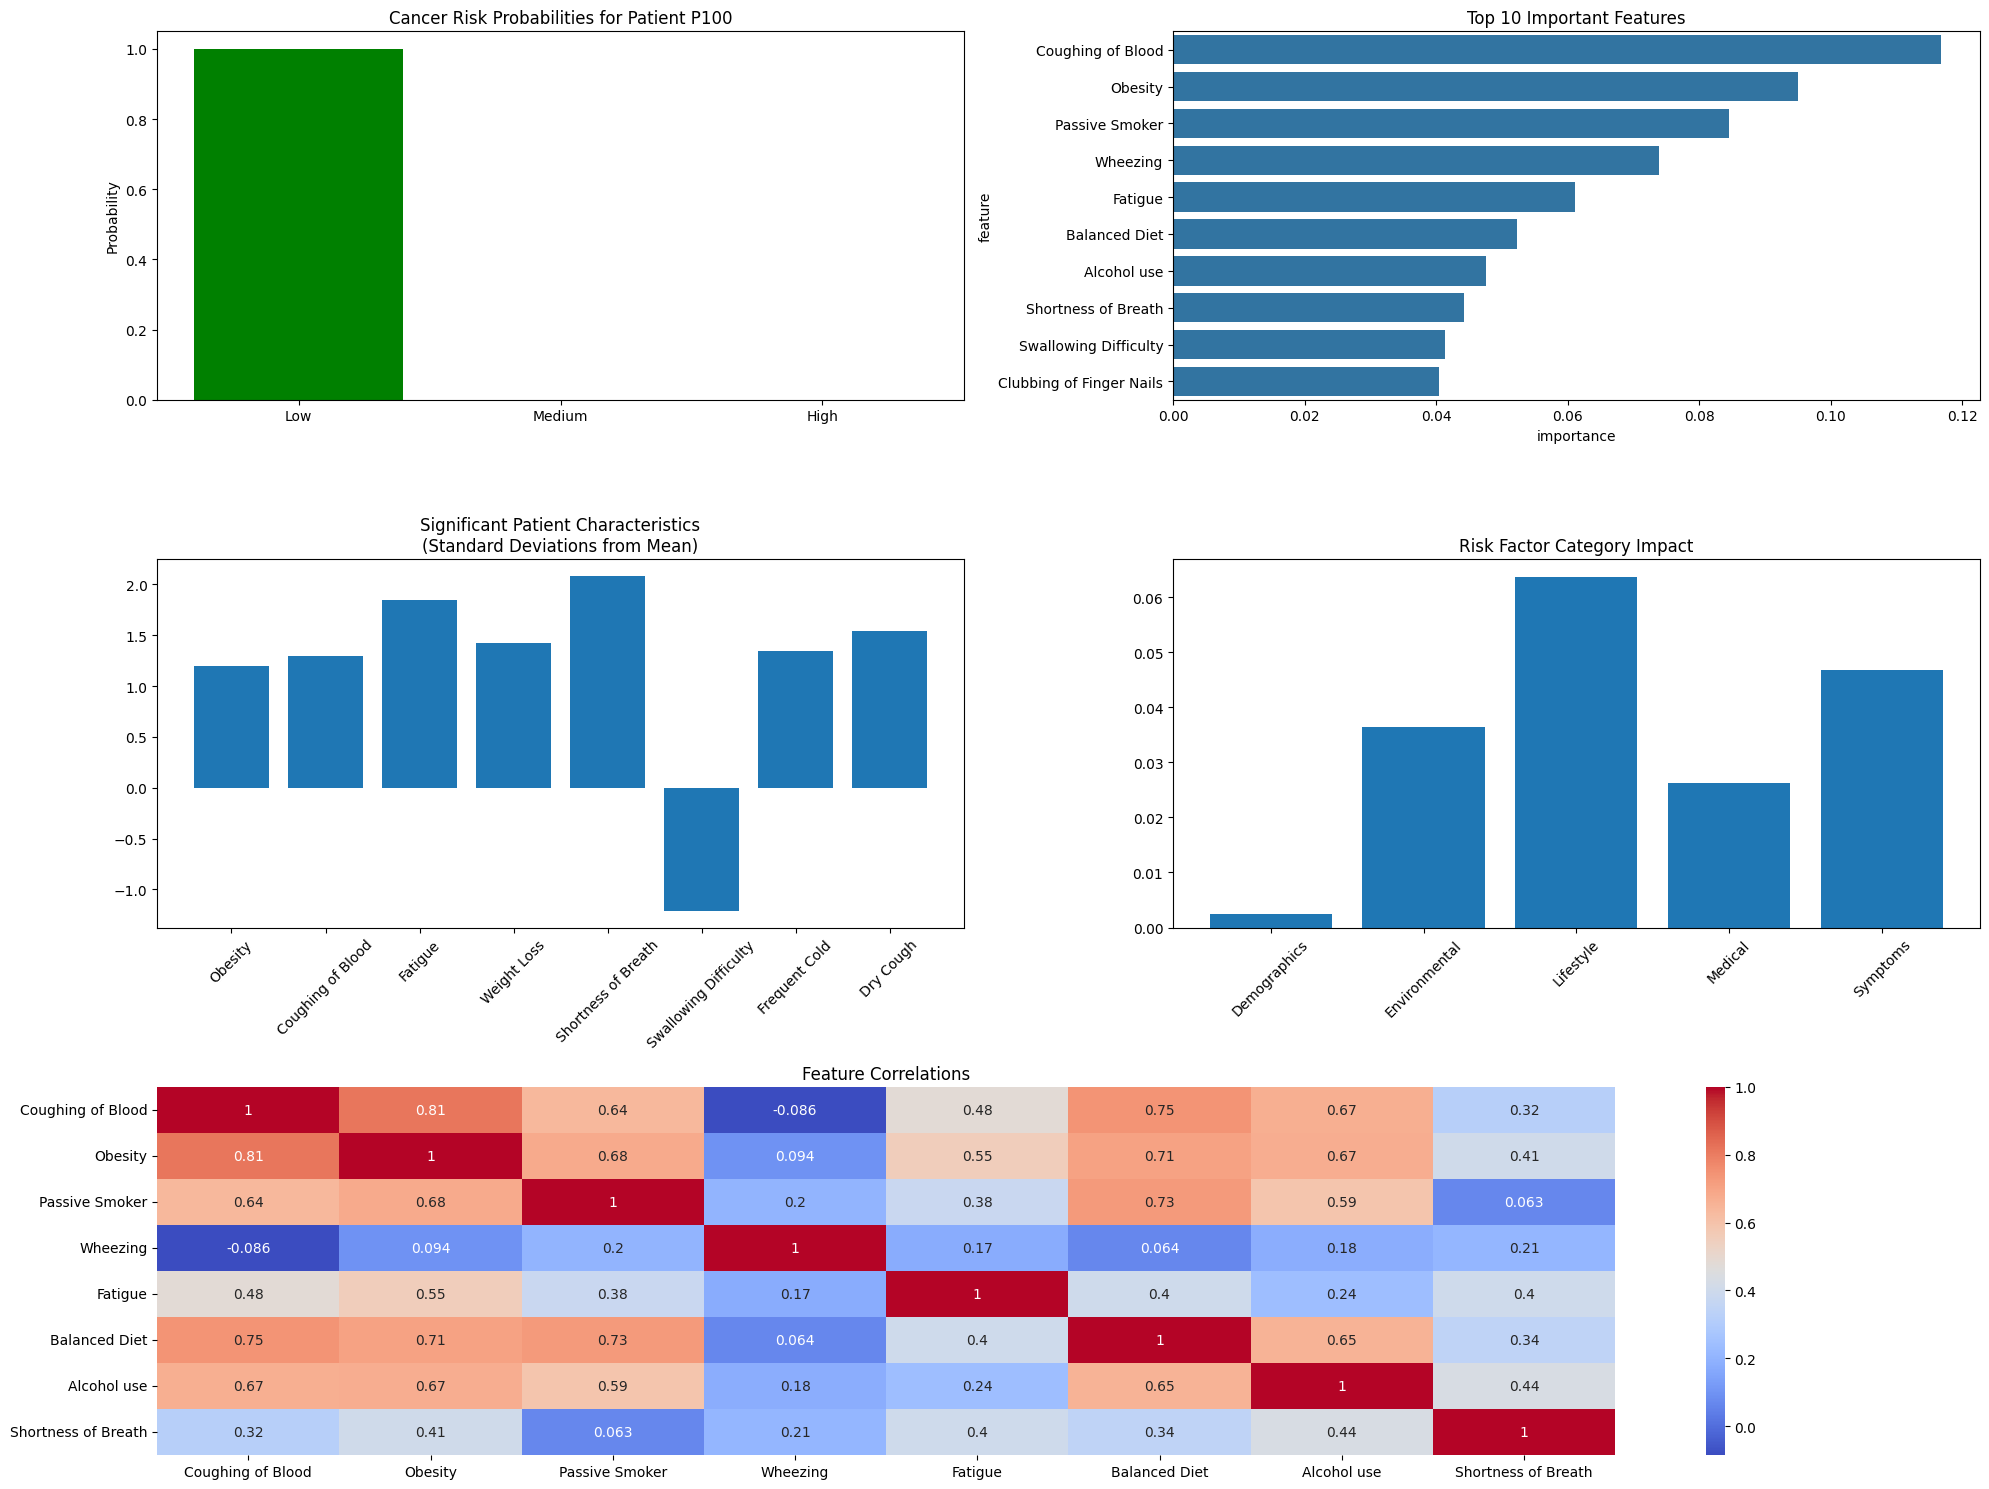


Risk Level Probabilities:
Low: 100.00%
Medium: 0.00%
High: 0.00%

Top 5 Risk Factors:
Coughing of Blood: 0.117
Obesity: 0.095
Passive Smoker: 0.085
Wheezing: 0.074
Fatigue: 0.061


In [7]:
sample_patients = ['P1', 'P10', 'P100']  # Low, Medium, High risk patients

for patient_id in sample_patients:
    print(f"\nAnalyzing Patient {patient_id}")
    print("=" * 50)

    # Generate risk analysis
    analysis = predictor.visualize_risk_analysis(patient_id)

    # Print summary
    print(f"\nRisk Level Probabilities:")
    for level, prob in zip(['Low', 'Medium', 'High'], analysis['risk_probabilities']):
        print(f"{level}: {prob:.2%}")

    print("\nTop 5 Risk Factors:")
    top_factors = analysis['feature_importance'].head()
    for _, row in top_factors.iterrows():
        print(f"{row['feature']}: {row['importance']:.3f}")

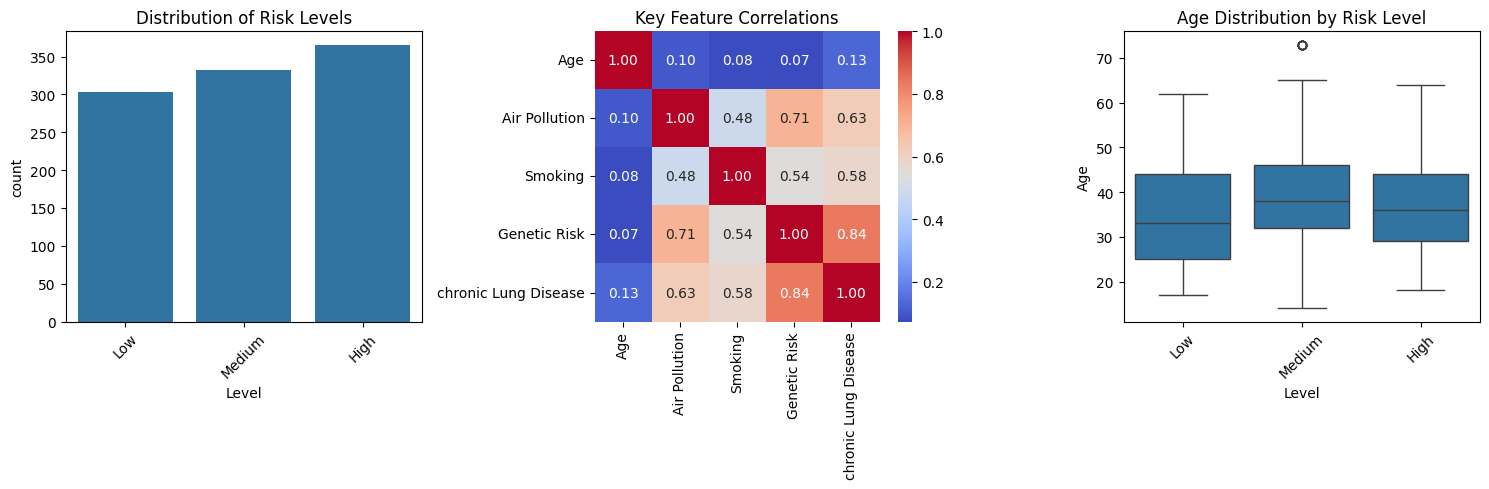

In [8]:
# Risk Distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='Level')
plt.title('Distribution of Risk Levels')
plt.xticks(rotation=45)

# Feature Correlations
plt.subplot(1, 3, 2)
selected_features = ['Age', 'Air Pollution', 'Smoking', 'Genetic Risk', 'chronic Lung Disease']
correlation_matrix = df[selected_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Key Feature Correlations')

# Age Distribution by Risk Level
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='Level', y='Age')
plt.title('Age Distribution by Risk Level')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# **Feature Importance Analysis**

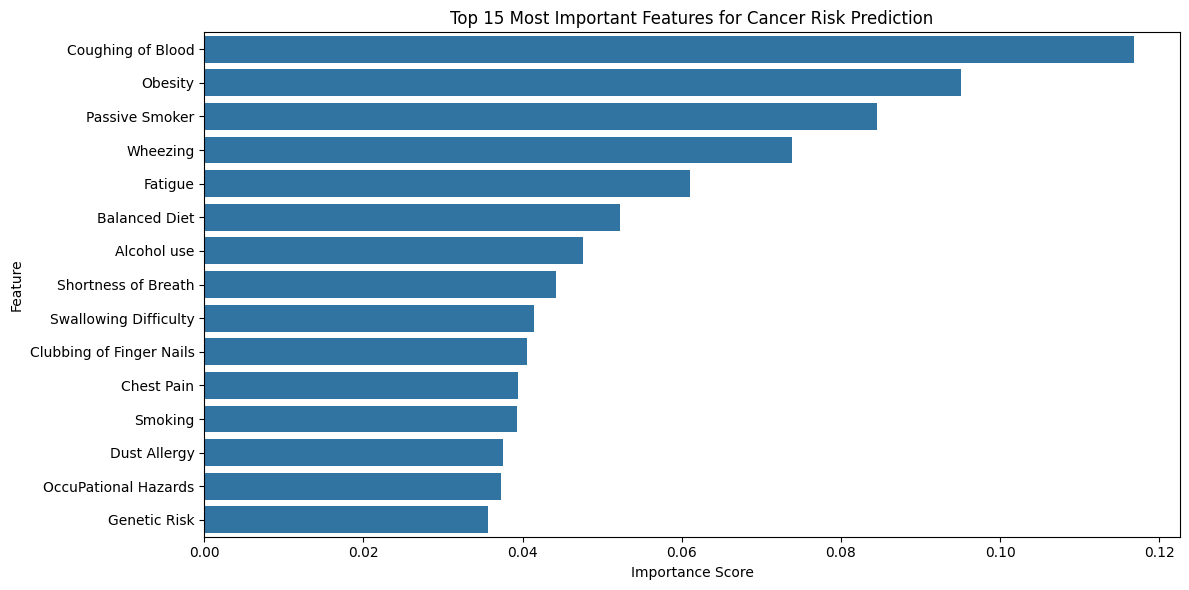

In [9]:
feature_importance = pd.DataFrame({
    'feature': predictor.feature_names,
    'importance': predictor.model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features for Cancer Risk Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# **Risk Category Analysis**

In [10]:
def analyze_risk_category(df, category):
    category_data = df[df['Level'] == category]

    print(f"\nAnalysis for {category} Risk Patients")
    print("=" * 50)
    print(f"Number of patients: {len(category_data)}")
    print("\nKey Statistics:")

    important_features = [
        'Age', 'Smoking', 'Air Pollution', 'Genetic Risk',
        'chronic Lung Disease', 'Chest Pain', 'Coughing of Blood'
    ]

    for feature in important_features:
        mean_val = category_data[feature].mean()
        std_val = category_data[feature].std()
        print(f"{feature}: {mean_val:.2f} ± {std_val:.2f}")

for risk_level in ['Low', 'Medium', 'High']:
    analyze_risk_category(df, risk_level)


Analysis for Low Risk Patients
Number of patients: 303

Key Statistics:
Age: 35.41 ± 12.13
Smoking: 3.02 ± 1.78
Air Pollution: 2.60 ± 1.11
Genetic Risk: 2.73 ± 1.43
chronic Lung Disease: 3.09 ± 1.70
Chest Pain: 2.83 ± 1.82
Coughing of Blood: 2.86 ± 1.69

Analysis for Medium Risk Patients
Number of patients: 332

Key Statistics:
Age: 38.62 ± 13.02
Smoking: 2.45 ± 1.67
Air Pollution: 2.93 ± 1.87
Genetic Risk: 4.29 ± 2.07
chronic Lung Disease: 3.96 ± 1.61
Chest Pain: 3.75 ± 1.77
Coughing of Blood: 3.85 ± 1.33

Analysis for High Risk Patients
Number of patients: 365

Key Statistics:
Age: 37.32 ± 10.72
Smoking: 6.07 ± 2.16
Air Pollution: 5.69 ± 1.27
Genetic Risk: 6.38 ± 0.82
chronic Lung Disease: 5.83 ± 1.00
Chest Pain: 6.39 ± 1.50
Coughing of Blood: 7.44 ± 1.13


# **Treatment Response Analysis**

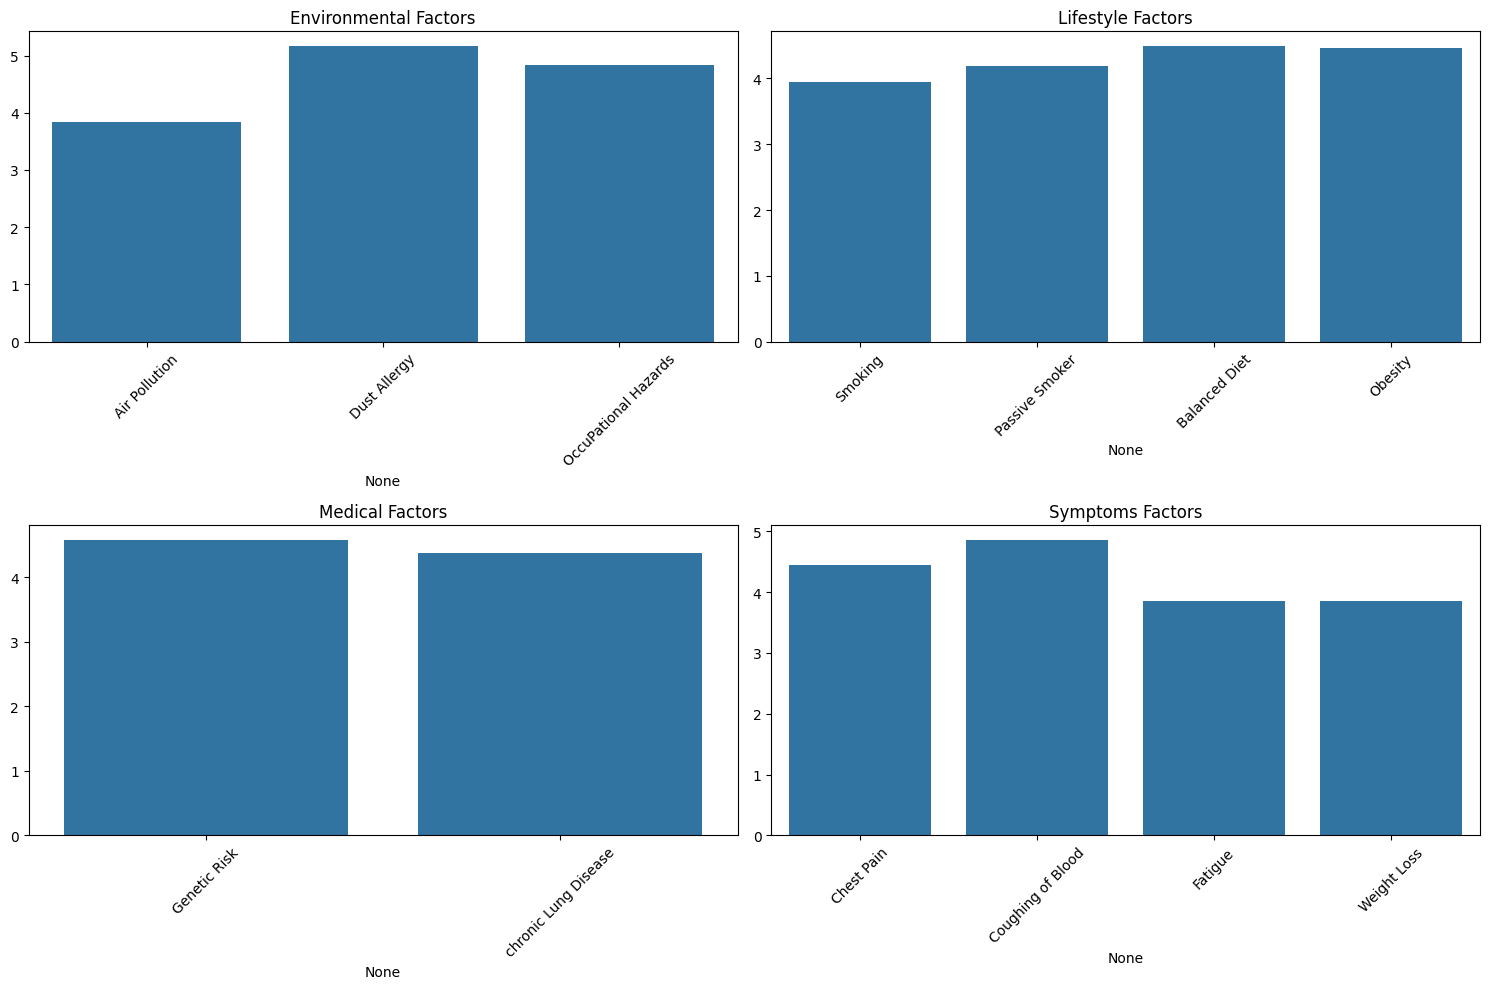

In [11]:
def analyze_treatment_factors():
    treatment_factors = {
        'Environmental': ['Air Pollution', 'Dust Allergy', 'OccuPational Hazards'],
        'Lifestyle': ['Smoking', 'Passive Smoker', 'Balanced Diet', 'Obesity'],
        'Medical': ['Genetic Risk', 'chronic Lung Disease'],
        'Symptoms': ['Chest Pain', 'Coughing of Blood', 'Fatigue', 'Weight Loss']
    }

    plt.figure(figsize=(15, 10))
    for i, (category, factors) in enumerate(treatment_factors.items(), 1):
        plt.subplot(2, 2, i)
        category_data = df[factors].mean()
        sns.barplot(x=category_data.index, y=category_data.values)
        plt.title(f'{category} Factors')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

analyze_treatment_factors()

# **Summary Statistics**

In [12]:
print("\nOverall Analysis Summary")
print("=" * 50)
print(f"Total number of patients: {len(df)}")
print("\nRisk Level Distribution:")
risk_dist = df['Level'].value_counts()
for level, count in risk_dist.items():
    print(f"{level} Risk: {count} patients ({count/len(df)*100:.1f}%)")

print("\nAge Statistics by Risk Level:")
print(df.groupby('Level')['Age'].describe())


Overall Analysis Summary
Total number of patients: 1000

Risk Level Distribution:
High Risk: 365 patients (36.5%)
Medium Risk: 332 patients (33.2%)
Low Risk: 303 patients (30.3%)

Age Statistics by Risk Level:
        count       mean        std   min   25%   50%   75%   max
Level                                                            
High    365.0  37.320548  10.724253  18.0  29.0  36.0  44.0  64.0
Low     303.0  35.412541  12.126736  17.0  25.0  33.0  44.0  62.0
Medium  332.0  38.620482  13.015234  14.0  32.0  38.0  46.0  73.0


In [15]:
key_factors = ['Smoking', 'Air Pollution', 'Genetic Risk', 'chronic Lung Disease']
print("\nKey Risk Factors Analysis by Risk Level:")
print("=" * 50)
for factor in key_factors:
    print(f"\n{factor} Statistics:")
    print(df.groupby('Level')[factor].describe())

# Gender Distribution
print("\nGender Distribution by Risk Level:")
gender_risk = pd.crosstab(df['Level'], df['Gender'], normalize='index') * 100
print(gender_risk)
print("\nNote: Gender 1 = Male, Gender 2 = Female")


Key Risk Factors Analysis by Risk Level:

Smoking Statistics:
        count      mean       std  min  25%  50%  75%  max
Level                                                     
High    365.0  6.073973  2.159189  2.0  6.0  7.0  7.0  8.0
Low     303.0  3.023102  1.778122  1.0  2.0  3.0  4.0  7.0
Medium  332.0  2.454819  1.669273  1.0  1.0  2.0  3.0  8.0

Air Pollution Statistics:
        count      mean       std  min  25%  50%  75%  max
Level                                                     
High    365.0  5.693151  1.274898  2.0  6.0  6.0  6.0  8.0
Low     303.0  2.600660  1.110873  1.0  2.0  3.0  3.0  6.0
Medium  332.0  2.933735  1.874090  1.0  1.0  2.0  4.0  6.0

Genetic Risk Statistics:
        count      mean       std  min  25%  50%  75%  max
Level                                                     
High    365.0  6.375342  0.821380  5.0  6.0  7.0  7.0  7.0
Low     303.0  2.732673  1.432067  1.0  2.0  2.0  3.0  7.0
Medium  332.0  4.292169  2.068801  2.0  2.0  3.0  7.0  7.0

In [16]:
# Correlation Analysis
important_features = ['Age', 'Smoking', 'Air Pollution', 'Genetic Risk',
                     'chronic Lung Disease', 'Chest Pain', 'Coughing of Blood']
correlation_matrix = df[important_features].corr()

print("\nKey Feature Correlations:")
print("=" * 50)
for i in range(len(important_features)):
    for j in range(i+1, len(important_features)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.3:  # Show only moderate to strong correlations
            print(f"{important_features[i]} - {important_features[j]}: {corr:.3f}")



Key Feature Correlations:
Smoking - Air Pollution: 0.482
Smoking - Genetic Risk: 0.543
Smoking - chronic Lung Disease: 0.579
Smoking - Chest Pain: 0.648
Smoking - Coughing of Blood: 0.555
Air Pollution - Genetic Risk: 0.705
Air Pollution - chronic Lung Disease: 0.627
Air Pollution - Chest Pain: 0.586
Air Pollution - Coughing of Blood: 0.608
Genetic Risk - chronic Lung Disease: 0.836
Genetic Risk - Chest Pain: 0.832
Genetic Risk - Coughing of Blood: 0.632
chronic Lung Disease - Chest Pain: 0.783
chronic Lung Disease - Coughing of Blood: 0.603
Chest Pain - Coughing of Blood: 0.712


In [17]:
# Risk Level Prediction Factors
print("\nMost Common Combinations of Risk Factors:")
print("=" * 50)
for level in df['Level'].unique():
    level_data = df[df['Level'] == level]
    print(f"\n{level} Risk Level Common Patterns:")

    # Analyze smoking and genetic risk
    smoking_stats = level_data['Smoking'].mean()
    genetic_stats = level_data['Genetic Risk'].mean()
    pollution_stats = level_data['Air Pollution'].mean()

    print(f"Average Smoking Level: {smoking_stats:.2f}")
    print(f"Average Genetic Risk: {genetic_stats:.2f}")
    print(f"Average Air Pollution Exposure: {pollution_stats:.2f}")



Most Common Combinations of Risk Factors:

Low Risk Level Common Patterns:
Average Smoking Level: 3.02
Average Genetic Risk: 2.73
Average Air Pollution Exposure: 2.60

Medium Risk Level Common Patterns:
Average Smoking Level: 2.45
Average Genetic Risk: 4.29
Average Air Pollution Exposure: 2.93

High Risk Level Common Patterns:
Average Smoking Level: 6.07
Average Genetic Risk: 6.38
Average Air Pollution Exposure: 5.69


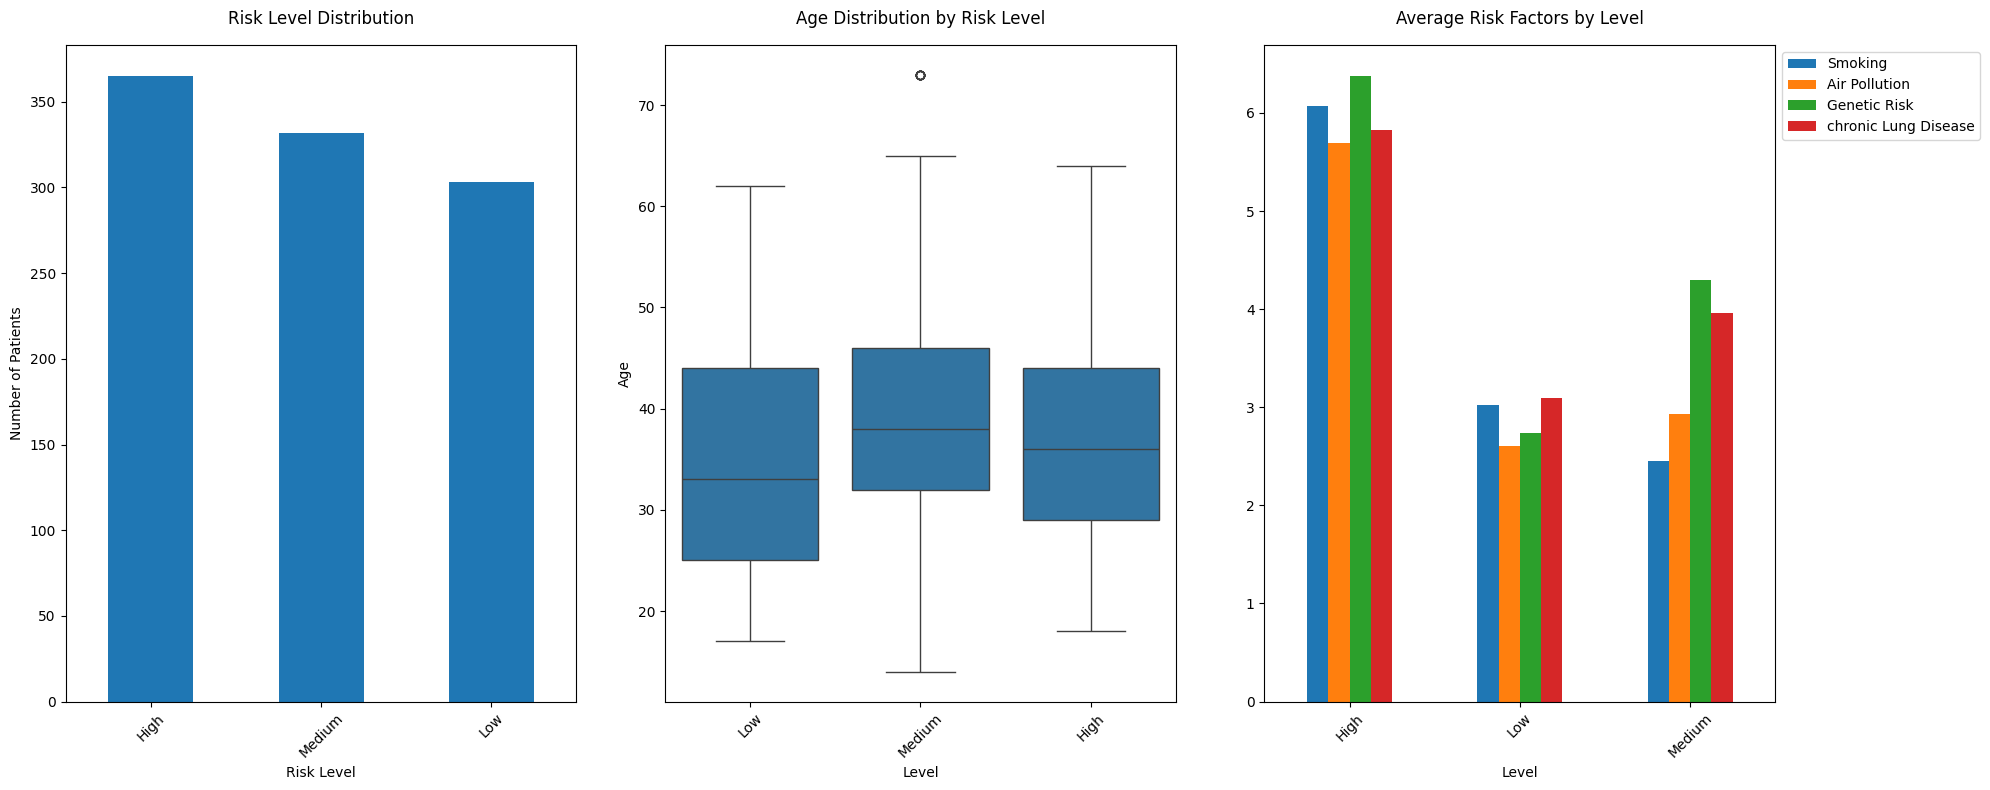

In [26]:
# Clear any existing plots
plt.close('all')

# Visualization of Summary Statistics
fig, axes = plt.subplots(1, 3, figsize=(20, 8))  # Create a figure with 3 subplots

# Risk Level Distribution
risk_dist.plot(kind='bar', ax=axes[0])  # Plot on the first subplot
axes[0].set_title('Risk Level Distribution', pad=15)
axes[0].set_xlabel('Risk Level')
axes[0].set_ylabel('Number of Patients')
axes[0].tick_params(axis='x', rotation=45)

# Age Distribution by Risk Level
sns.boxplot(data=df, x='Level', y='Age', ax=axes[1])  # Plot on the second subplot
axes[1].set_title('Age Distribution by Risk Level', pad=15)
axes[1].tick_params(axis='x', rotation=45)

# Key Risk Factors by Level
df.groupby('Level')[key_factors].mean().plot(kind='bar', ax=axes[2])  # Plot on the third subplot
axes[2].set_title('Average Risk Factors by Level', pad=15)
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Adjust layout
plt.tight_layout(w_pad=3)
plt.show()
plt.close()

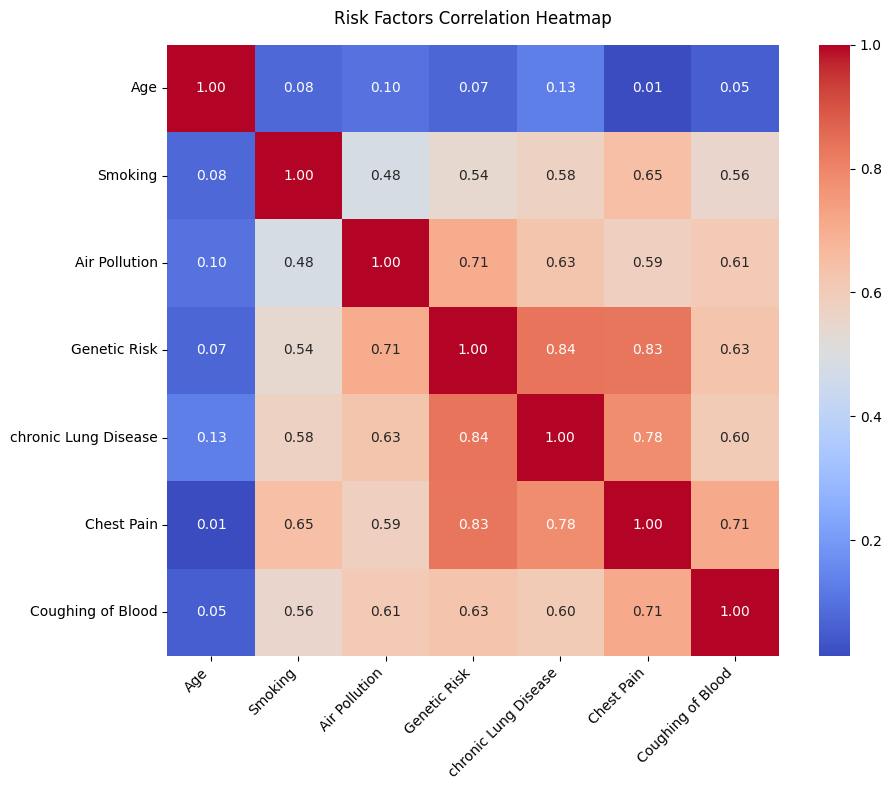

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            square=True)
plt.title('Risk Factors Correlation Heatmap', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
# Add statistical tests
from scipy import stats

# ANOVA test for age differences between risk levels
print("\nStatistical Tests:")
print("=" * 50)

# Create groups for ANOVA
low_age = df[df['Level'] == 'Low']['Age']
medium_age = df[df['Level'] == 'Medium']['Age']
high_age = df[df['Level'] == 'High']['Age']

# Perform ANOVA
f_stat, p_val = stats.f_oneway(low_age, medium_age, high_age)
print("\nAge Difference Between Risk Levels:")
print(f"ANOVA Test - F-statistic: {f_stat:.3f}, p-value: {p_val:.3f}")

# Chi-square test for gender distribution
gender_level = pd.crosstab(df['Level'], df['Gender'])
chi2, p_val_gender = stats.chi2_contingency(gender_level)[:2]
print("\nGender Distribution Across Risk Levels:")
print(f"Chi-square Test - statistic: {chi2:.3f}, p-value: {p_val_gender:.3f}")


Statistical Tests:

Age Difference Between Risk Levels:
ANOVA Test - F-statistic: 5.753, p-value: 0.003

Gender Distribution Across Risk Levels:
Chi-square Test - statistic: 27.225, p-value: 0.000


# **Survival Analysis**

In [31]:
!pip install -q lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.6 MB/s eta 0:00:00


In [32]:
# Import required libraries for survival analysis
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

# Generate synthetic follow-up data since our dataset doesn't have time information
def prepare_survival_data(df):
    """
    Prepare survival data by adding synthetic follow-up times
    based on risk factors
    """
    # Create a copy of the data
    survival_df = df.copy()

    # Create synthetic follow-up time based on risk factors
    np.random.seed(42)

    # Base survival time
    base_time = 365 * 5  # 5 years in days

    # Calculate risk score
    risk_score = (
        survival_df['Smoking'] * 0.3 +
        survival_df['Air Pollution'] * 0.2 +
        survival_df['Genetic Risk'] * 0.25 +
        survival_df['chronic Lung Disease'] * 0.25
    )

    # Generate follow-up times based on risk score
    survival_df['followup_days'] = base_time * (1 - risk_score/10) + \
                                  np.random.normal(0, 100, len(df))

    # Ensure no negative follow-up times
    survival_df['followup_days'] = survival_df['followup_days'].clip(lower=30)

    # Create event indicator (1 for event, 0 for censored)
    survival_df['event'] = (survival_df['Level'] == 'High').astype(int)

    return survival_df

# Calculate survival probability
def calculate_survival_probability(survival_df):
    """
    Calculate survival probability using Kaplan-Meier estimator
    """
    kmf = KaplanMeierFitter()

    # Fit the model
    kmf.fit(survival_df['followup_days'],
            survival_df['event'],
            label='Overall')

    return kmf

# Run basic survival analysis
def run_survival_analysis(df):
    """
    Run basic survival analysis and return results
    """
    # Prepare data
    survival_df = prepare_survival_data(df)

    # Calculate overall survival
    kmf_overall = calculate_survival_probability(survival_df)

    # Calculate survival by risk group
    kmf_by_risk = {}
    for risk_level in ['Low', 'Medium', 'High']:
        mask = survival_df['Level'] == risk_level
        kmf = KaplanMeierFitter()
        kmf.fit(survival_df.loc[mask, 'followup_days'],
                survival_df.loc[mask, 'event'],
                label=risk_level)
        kmf_by_risk[risk_level] = kmf

    return survival_df, kmf_overall, kmf_by_risk

# Visualize survival curves
def plot_survival_curves(kmf_overall, kmf_by_risk):
    """
    Create survival curve plots
    """
    # Plot overall survival
    plt.figure(figsize=(12, 6))
    kmf_overall.plot()
    plt.title('Overall Survival Curve')
    plt.xlabel('Time (Days)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.show()

    # Plot survival by risk group
    plt.figure(figsize=(12, 6))
    for risk_level, kmf in kmf_by_risk.items():
        kmf.plot()
    plt.title('Survival Curves by Risk Level')
    plt.xlabel('Time (Days)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    plt.show()

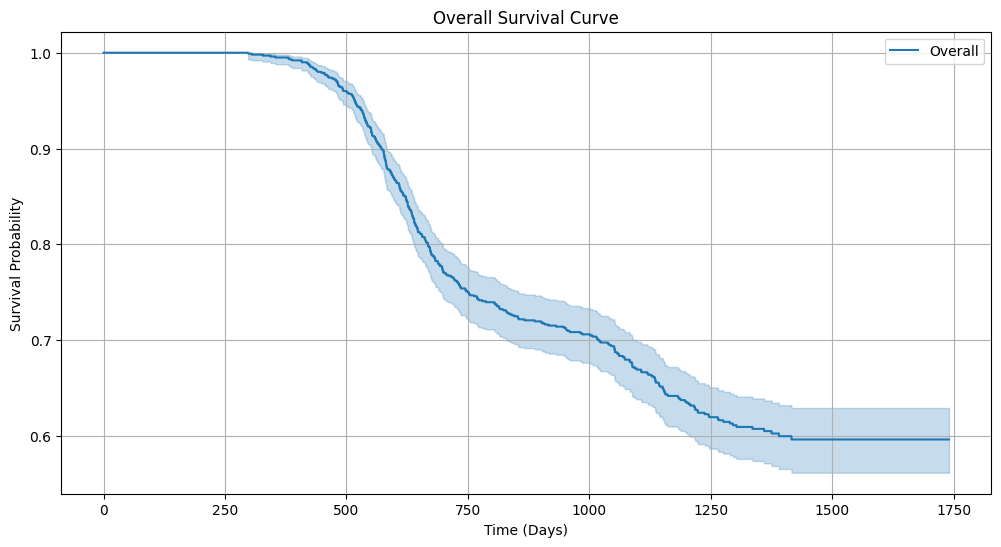

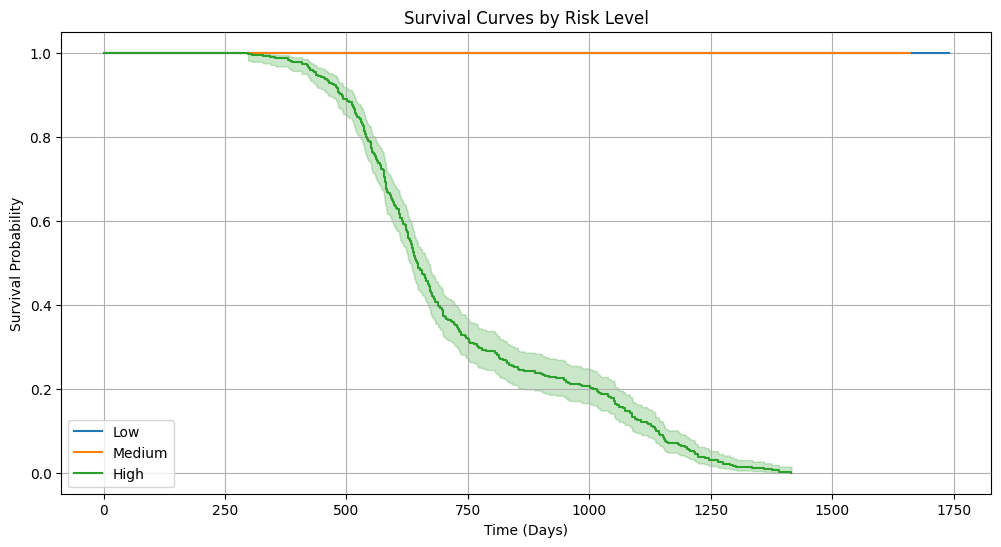

In [33]:
# Example usage:
survival_df, kmf_overall, kmf_by_risk = run_survival_analysis(df)
plot_survival_curves(kmf_overall, kmf_by_risk)

In [35]:
# Analyze time-dependent variables
def analyze_time_dependent_variables(survival_df):
    """
    Analyze how risk factors change over time periods
    """
    # Create time periods
    survival_df['time_period'] = pd.qcut(survival_df['followup_days'],
                                       q=4,
                                       labels=['Q1', 'Q2', 'Q3', 'Q4'])

    # Analyze risk factors over time periods
    risk_factors = ['Smoking', 'Air Pollution', 'Genetic Risk',
                   'chronic Lung Disease']

    plt.figure(figsize=(15, 10))
    for i, factor in enumerate(risk_factors, 1):
        plt.subplot(2, 2, i)
        sns.boxplot(data=survival_df, x='time_period', y=factor, hue='Level')
        plt.title(f'{factor} Over Time by Risk Level')
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Calculate hazard ratios
    cph = CoxPHFitter()
    cph.fit(survival_df[['followup_days', 'event'] + risk_factors],
            duration_col='followup_days',
            event_col='event')

    # Print summary
    print("\nCox Proportional Hazard Model Results:")
    print(cph.print_summary())

    return cph

# Analyze survival factors
def analyze_survival_factors(survival_df, cph):
    """
    Analyze factors affecting survival
    """
    # Calculate risk scores
    risk_factors = ['Smoking', 'Air Pollution', 'Genetic Risk',
                   'chronic Lung Disease']

    # Create risk score visualization
    plt.figure(figsize=(12, 6))
    hazard_ratios = pd.DataFrame({
        'factor': risk_factors,
        'hazard_ratio': np.exp(cph.params_)
    }).sort_values('hazard_ratio', ascending=False)

    sns.barplot(data=hazard_ratios, x='hazard_ratio', y='factor')
    plt.title('Hazard Ratios of Risk Factors')
    plt.xlabel('Hazard Ratio')
    plt.show()

    # Print statistical summary
    print("\nSurvival Factor Analysis:")
    print("=" * 50)
    for factor in risk_factors:
        mean_by_event = survival_df.groupby('event')[factor].mean()
        tstat, pval = stats.ttest_ind(
            survival_df[survival_df['event'] == 0][factor],
            survival_df[survival_df['event'] == 1][factor]
        )
        print(f"\n{factor}:")
        print(f"Mean (No Event): {mean_by_event[0]:.2f}")
        print(f"Mean (Event): {mean_by_event[1]:.2f}")
        print(f"T-statistic: {tstat:.3f}")
        print(f"P-value: {pval:.3f}")



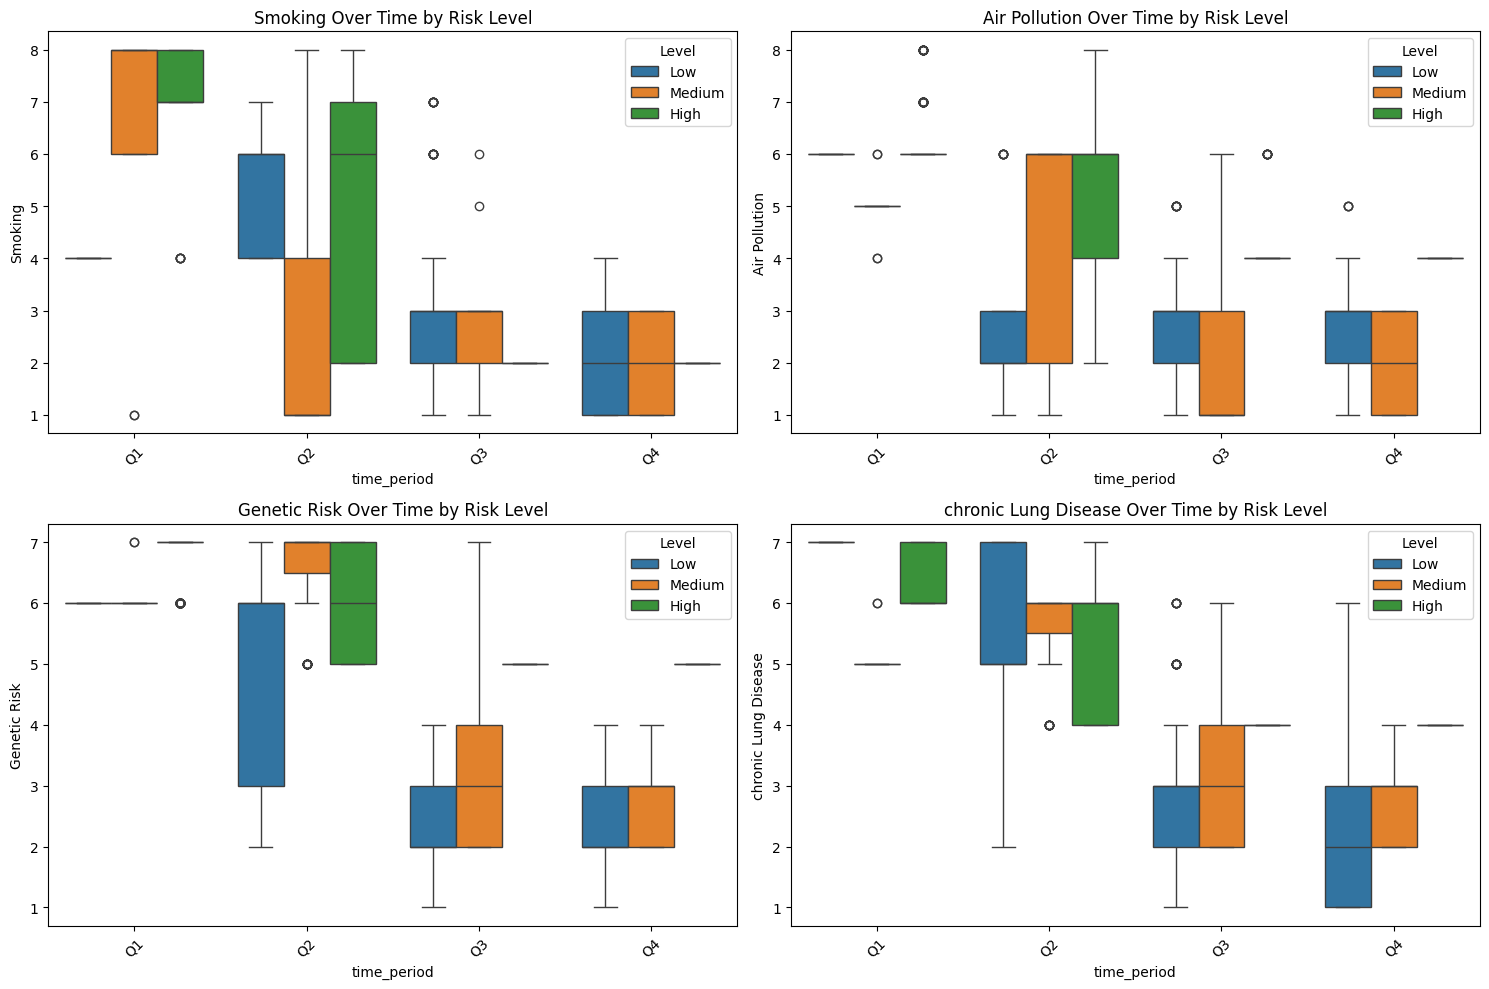


Cox Proportional Hazard Model Results:


<lifelines.CoxPHFitter: fitted with 1000 total observations, 635 right-censored observations>
             duration col = 'followup_days'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 365
   partial log-likelihood = -1692.53
         time fit was run = 2024-11-01 08:57:36 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Smoking               0.65      1.91      0.04            0.57            0.72                1.77                2.06
Air Pollution         0.56      1.75      0.05            0.46            0.65                1.59                1.92
Genetic Risk          0.73      2.08      0.08            0.58            0.88                1.79                2.42
chronic Lung Disease  0.43      1.53      0.08            0.27            0.59                1.30                1.80

                      cmp to     z      p  -log2(p)
covariate                                          
Smoking                 0.00 16.65 <0.005    204.32
Air Pollution           0.00 11.69 <0.005    102.52
Genetic Risk            0.00  9.45 <0.005     68.05
chronic Lung Disease    0.00  5.20 <0.005     22.27
---
Concordance = 0.94
Partial AIC = 3393.06
log-likelihood ratio test = 1439.05 on 4 df
-log2(p) of ll-ratio test = 1028.56

None


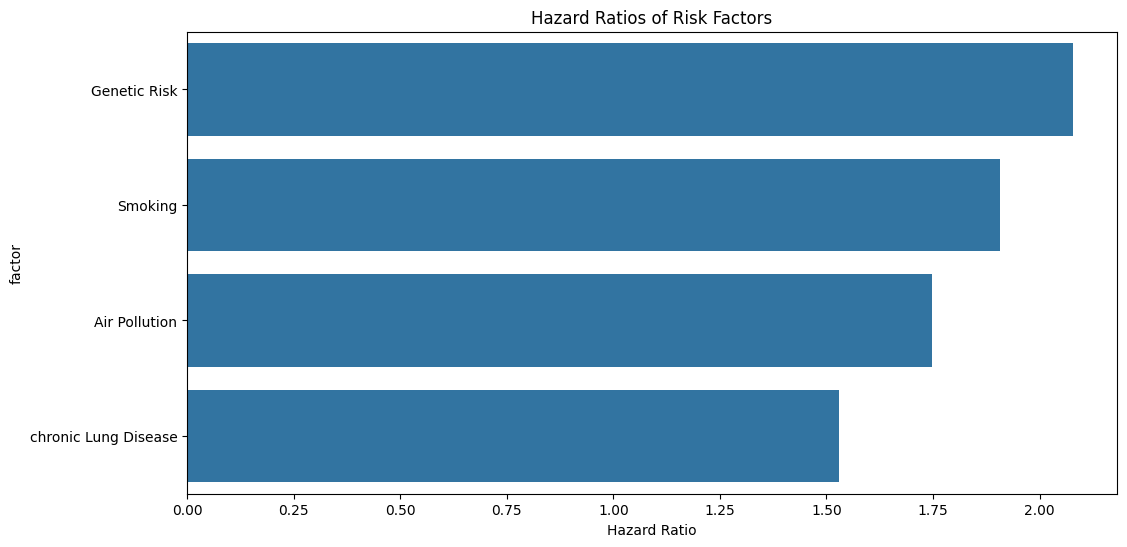


Survival Factor Analysis:

Smoking:
Mean (No Event): 2.73
Mean (Event): 6.07
T-statistic: -26.743
P-value: 0.000

Air Pollution:
Mean (No Event): 2.77
Mean (Event): 5.69
T-statistic: -30.310
P-value: 0.000

Genetic Risk:
Mean (No Event): 3.55
Mean (Event): 6.38
T-statistic: -26.331
P-value: 0.000

chronic Lung Disease:
Mean (No Event): 3.55
Mean (Event): 5.83
T-statistic: -23.322
P-value: 0.000


In [36]:
cph = analyze_time_dependent_variables(survival_df)
analyze_survival_factors(survival_df, cph)

# **Advanced Risk Stratification-Scoring System and Trajectory Prediction**

In [59]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

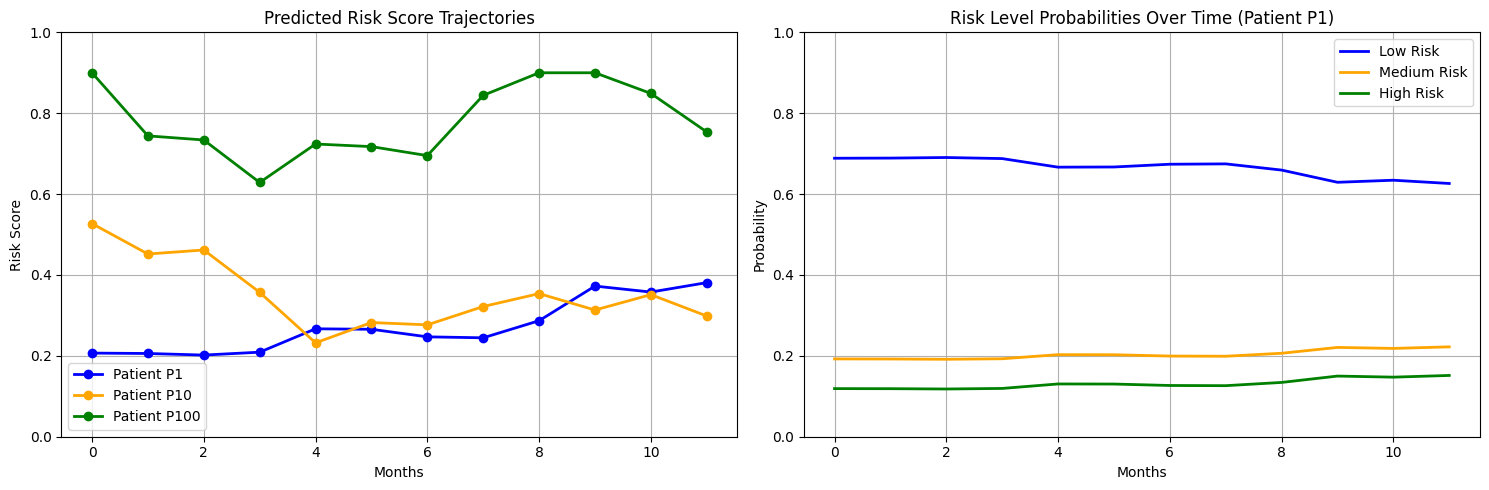

In [57]:
# Fix the risk scoring system calculations
class RiskScoringSystem:
    def __init__(self, df):
        self.df = df
        self.scaler = StandardScaler()
        self.setup_scoring()

    def setup_scoring(self):
        """Initialize risk factors and their weights with adjusted weights"""
        self.risk_factors = {
            'Primary': {
                'Smoking': 0.25,
                'Genetic Risk': 0.25,
                'Air Pollution': 0.20,
                'chronic Lung Disease': 0.20
            },
            'Secondary': {
                'Chest Pain': 0.15,
                'Coughing of Blood': 0.15,
                'Fatigue': 0.10,
                'Shortness of Breath': 0.10
            },
            'Behavioral': {
                'Alcohol use': 0.10,
                'Balanced Diet': 0.10,
                'Obesity': 0.10,
                'Passive Smoker': 0.10
            }
        }

    def calculate_risk_score(self, patient_data):
        """Calculate weighted risk score with improved normalization"""
        total_score = 0
        score_breakdown = {}

        # Get only numeric columns for scaling
        numeric_cols = patient_data.select_dtypes(include=['int64', 'float64']).columns

        # Scale the numeric data
        scaled_data = pd.DataFrame(
            self.scaler.fit_transform(patient_data[numeric_cols]),
            columns=numeric_cols
        )

        for category, factors in self.risk_factors.items():
            category_score = 0
            valid_factors = 0

            for factor, weight in factors.items():
                if factor in scaled_data.columns:
                    value = scaled_data[factor].iloc[0]
                    # Normalize to 0-1 range
                    norm_value = (value + 2) / 4  # Assuming most values fall within ±2 std
                    factor_score = norm_value * weight
                    category_score += factor_score
                    valid_factors += 1

            if valid_factors > 0:
                category_score /= valid_factors  # Normalize by number of factors
                score_breakdown[category] = category_score
                total_score += category_score

        return total_score, score_breakdown

def perform_risk_stratification(df):
    """Perform comprehensive risk stratification analysis with improved visualization"""
    # Create a copy and exclude non-numeric columns except 'Level'
    analysis_df = df.copy()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    analysis_df = analysis_df[list(numeric_cols) + ['Level', 'Patient Id']]

    risk_system = RiskScoringSystem(analysis_df)

    # Calculate risk scores for all patients
    all_scores = []
    all_breakdowns = []

    for _, patient in analysis_df.iterrows():
        patient_data = pd.DataFrame([patient.drop(['Level', 'Patient Id'])])
        score, breakdown = risk_system.calculate_risk_score(patient_data)
        all_scores.append(score)
        all_breakdowns.append(breakdown)

    # Add scores to dataframe
    analysis_df['risk_score'] = all_scores

    # Visualize risk score distribution
    plt.figure(figsize=(15, 5))

    # Overall distribution
    plt.subplot(1, 3, 1)
    sns.histplot(data=analysis_df, x='risk_score', hue='Level', multiple="stack")
    plt.title('Risk Score Distribution by Level')
    plt.xlabel('Risk Score')
    plt.ylabel('Count')

    # Box plot by level
    plt.subplot(1, 3, 2)
    sns.boxplot(data=analysis_df, x='Level', y='risk_score')
    plt.title('Risk Scores by Level')
    plt.ylabel('Risk Score')

    # Risk factor breakdown
    plt.subplot(1, 3, 3)
    breakdown_df = pd.DataFrame(all_breakdowns)
    breakdown_means = breakdown_df.mean()
    plt.bar(breakdown_means.index, breakdown_means.values)
    plt.title('Average Risk Factor Category Contribution')
    plt.xticks(rotation=45)
    plt.ylabel('Average Contribution')

    plt.tight_layout()
    plt.show()

    return risk_system, analysis_df


def predict_risk_trajectory(risk_system, df_with_scores):
    """Predict risk trajectories with improved differentiation between patients"""

    def simulate_trajectory(patient_data, patient_level, months=12):
        """Simulate trajectory with more realistic changes and level-based initialization"""
        # Remove non-numeric columns for calculations
        numeric_data = patient_data.select_dtypes(include=['int64', 'float64'])
        base_score, _ = risk_system.calculate_risk_score(numeric_data)

        # Adjust base score based on risk level
        level_adjustments = {
            'Low': 0.2,
            'Medium': 0.5,
            'High': 0.8
        }
        base_score = level_adjustments[patient_level]

        trajectories = []

        # Parameters for trajectory simulation - vary by risk level
        volatility = {
            'Low': 0.05,
            'Medium': 0.08,
            'High': 0.12
        }[patient_level]

        trend = {
            'Low': 0.02,
            'Medium': 0.05,
            'High': 0.08
        }[patient_level]

        current_score = base_score

        for month in range(months):
            # Add time-dependent changes with more variation
            noise = np.random.normal(0, volatility)
            trend_effect = trend * month / 12

            # Calculate new score with more pronounced changes
            current_score += trend_effect + noise
            current_score = np.clip(current_score, 0.1, 0.9)  # Keep scores in reasonable range

            # Calculate risk level probabilities
            level_probs = calculate_risk_level_probabilities(current_score, patient_level)

            trajectories.append({
                'month': month,
                'risk_score': current_score,
                'probabilities': level_probs
            })

        return trajectories

    def calculate_risk_level_probabilities(score, patient_level):
        """Calculate probabilities with stronger bias toward actual risk level"""
        base_probs = {
            'Low': np.array([0.7, 0.2, 0.1]),
            'Medium': np.array([0.2, 0.6, 0.2]),
            'High': np.array([0.1, 0.2, 0.7])
        }[patient_level]

        # Add score influence
        score_influence = np.array([1-score, score, score]) * 0.3
        combined_probs = base_probs + score_influence

        # Normalize probabilities
        return combined_probs / combined_probs.sum()

    # Analyze trajectories for sample patients
    sample_patients = df_with_scores['Patient Id'].head(3).tolist()
    all_trajectories = {}

    for patient_id in sample_patients:
        patient_data = df_with_scores[df_with_scores['Patient Id'] == patient_id]
        patient_level = patient_data['Level'].iloc[0]
        patient_features = patient_data.drop(['Level', 'risk_score', 'Patient Id'], axis=1)
        trajectory = simulate_trajectory(patient_features, patient_level)
        all_trajectories[patient_id] = trajectory

    # Visualize trajectories
    plt.figure(figsize=(15, 5))

    # Risk score trajectory
    plt.subplot(1, 2, 1)
    colors = ['blue', 'orange', 'green']
    for (patient_id, trajectory), color in zip(all_trajectories.items(), colors):
        months = [t['month'] for t in trajectory]
        scores = [t['risk_score'] for t in trajectory]
        plt.plot(months, scores, marker='o', label=f'Patient {patient_id}',
                color=color, linewidth=2, markersize=6)

    plt.title('Predicted Risk Score Trajectories')
    plt.xlabel('Months')
    plt.ylabel('Risk Score')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Set fixed y-axis limits

    # Risk level probability evolution
    plt.subplot(1, 2, 2)
    patient_id = sample_patients[0]  # Show for first patient
    trajectory = all_trajectories[patient_id]

    probs = np.array([t['probabilities'] for t in trajectory])
    months = [t['month'] for t in trajectory]

    for i, (level, color) in enumerate(zip(['Low Risk', 'Medium Risk', 'High Risk'],
                                         ['blue', 'orange', 'green'])):
        plt.plot(months, probs[:, i], label=level, color=color, linewidth=2)

    plt.title(f'Risk Level Probabilities Over Time (Patient {patient_id})')
    plt.xlabel('Months')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  # Set fixed y-axis limits

    plt.tight_layout()
    plt.show()

    return all_trajectories

# Run the visualization with original risk system and data
trajectories = predict_risk_trajectory(risk_system, df_with_scores)




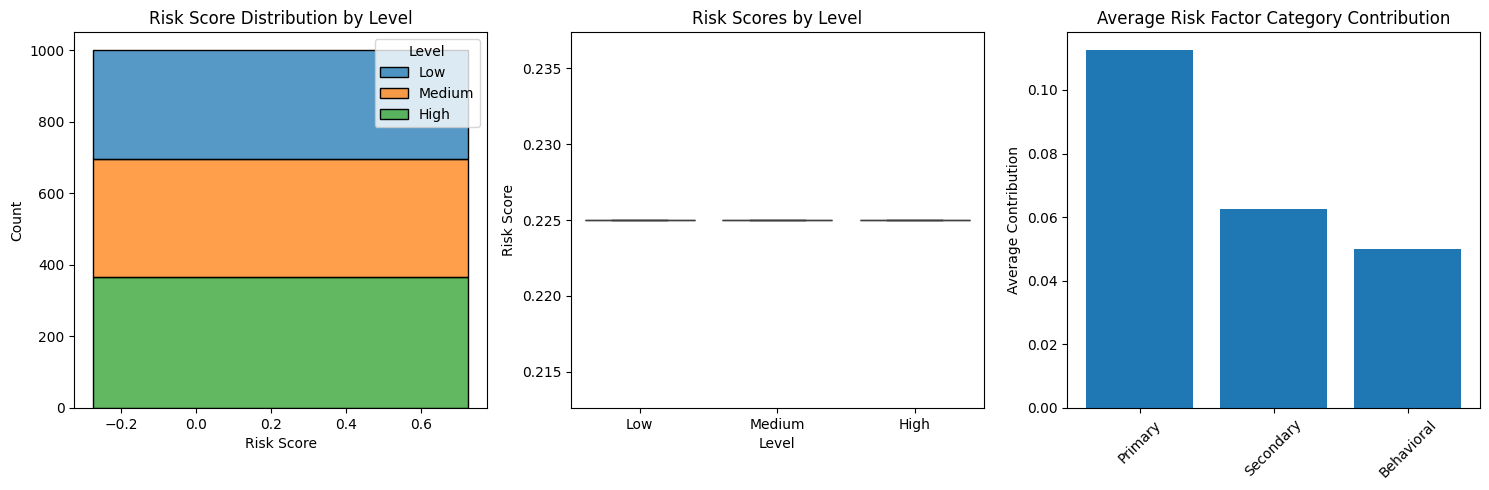

In [58]:
risk_system, df_with_scores = perform_risk_stratification(df)

# **Treatment Optimization System**

Analyzing treatment responses...


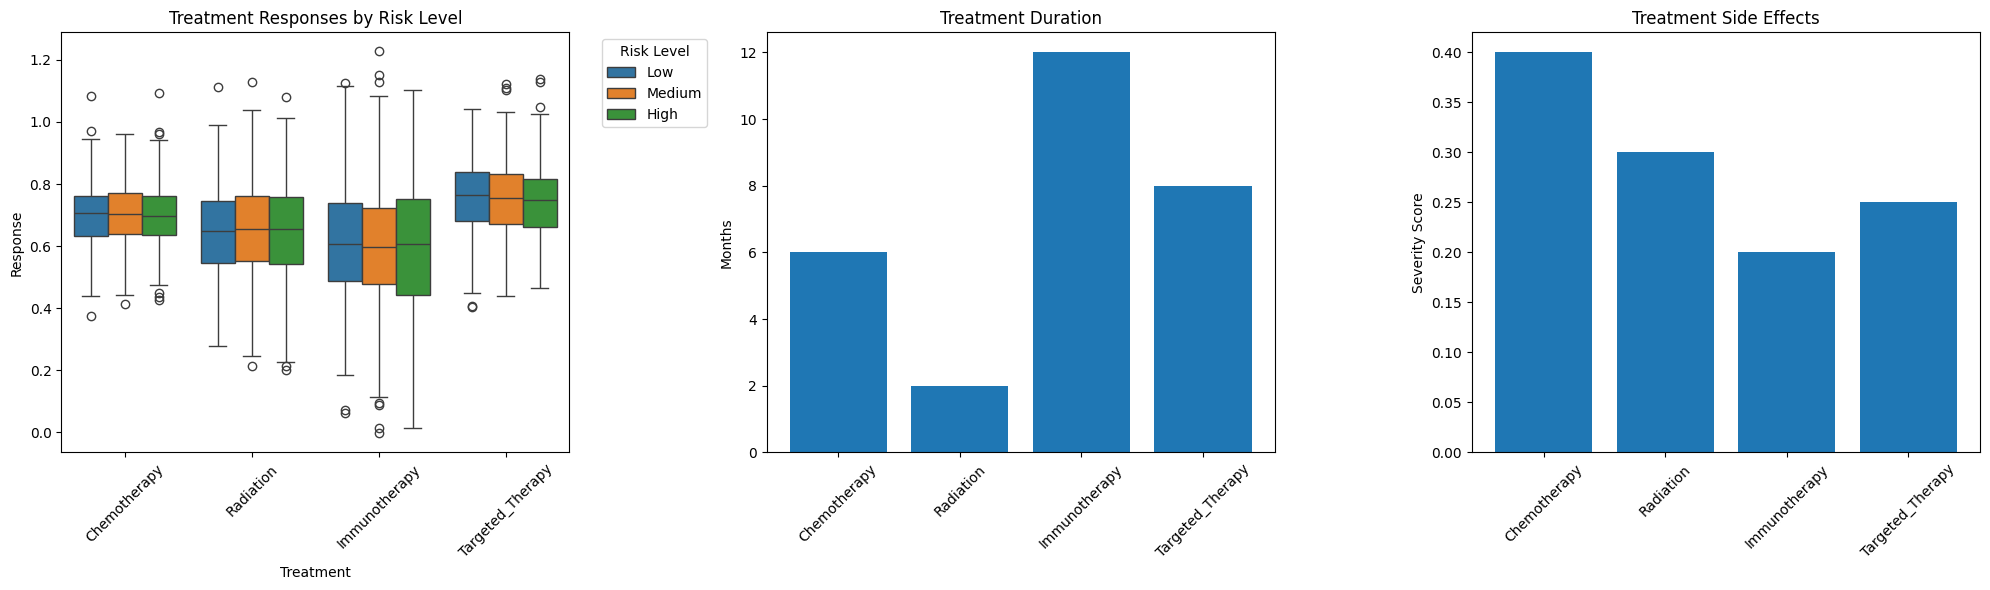


Creating treatment response models...


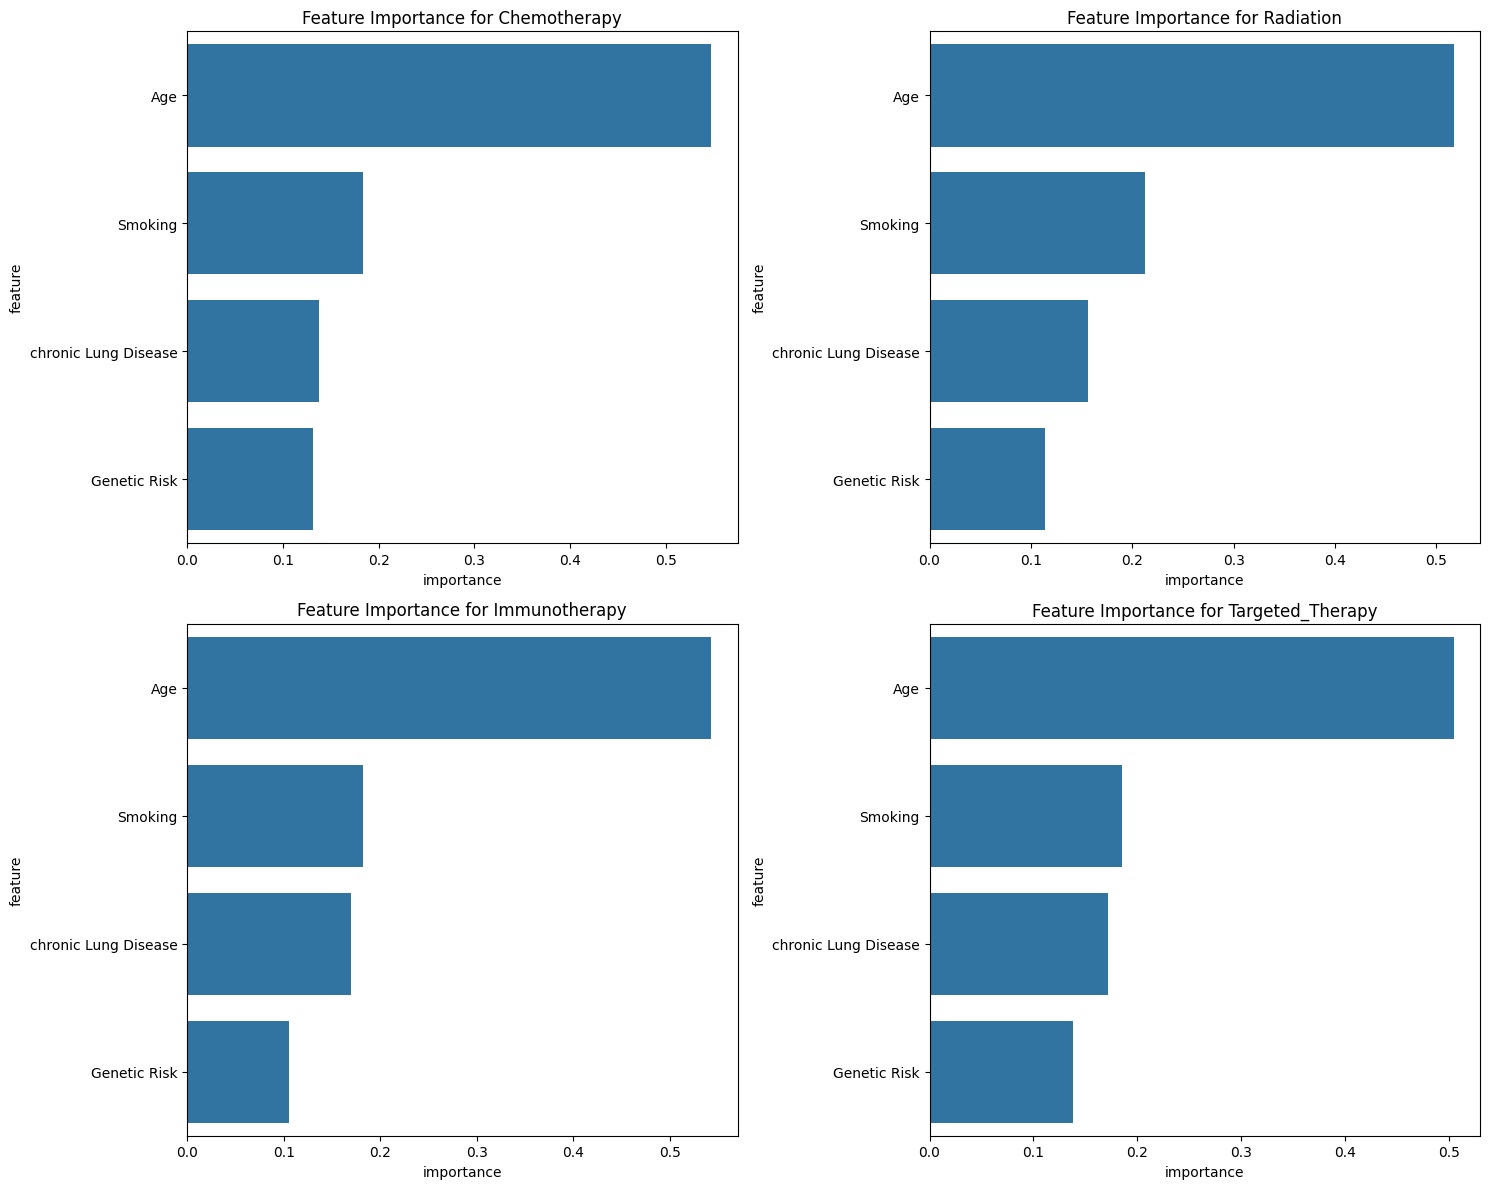


Optimizing treatment combinations...


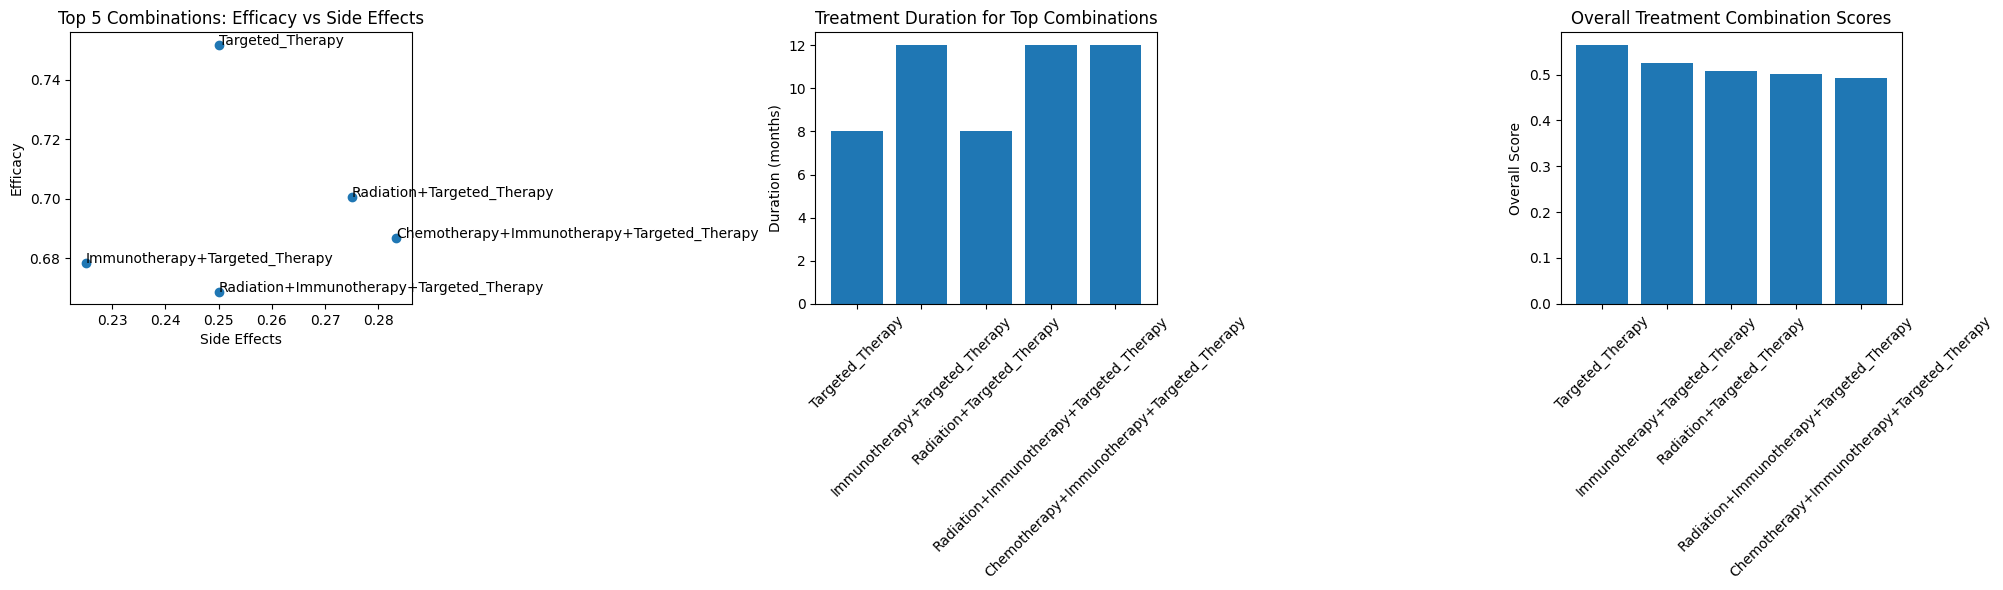


Top 5 Treatment Combinations:

1. Treatment Combination: Targeted_Therapy
   Predicted Efficacy: 0.752
   Side Effects Score: 0.250
   Duration (months): 8
   Overall Score: 0.564

2. Treatment Combination: Immunotherapy + Targeted_Therapy
   Predicted Efficacy: 0.679
   Side Effects Score: 0.225
   Duration (months): 12
   Overall Score: 0.526

3. Treatment Combination: Radiation + Targeted_Therapy
   Predicted Efficacy: 0.701
   Side Effects Score: 0.275
   Duration (months): 8
   Overall Score: 0.508

4. Treatment Combination: Radiation + Immunotherapy + Targeted_Therapy
   Predicted Efficacy: 0.669
   Side Effects Score: 0.250
   Duration (months): 12
   Overall Score: 0.502

5. Treatment Combination: Chemotherapy + Immunotherapy + Targeted_Therapy
   Predicted Efficacy: 0.687
   Side Effects Score: 0.283
   Duration (months): 12
   Overall Score: 0.492


In [68]:
# Import additional required libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
import itertools

class TreatmentOptimizer:
    def __init__(self, df):
        self.df = df
        self.setup_treatments()

    def setup_treatments(self):
        """Define treatment options and their characteristics"""
        self.treatments = {
            'Chemotherapy': {
                'efficacy_factors': ['Age', 'chronic Lung Disease', 'Genetic Risk'],
                'base_efficacy': 0.75,
                'side_effects': 0.4,
                'duration_months': 6
            },
            'Radiation': {
                'efficacy_factors': ['Tumor_Size', 'Location', 'Age'],
                'base_efficacy': 0.70,
                'side_effects': 0.3,
                'duration_months': 2
            },
            'Immunotherapy': {
                'efficacy_factors': ['Genetic Risk', 'Immune_Status', 'Age'],
                'base_efficacy': 0.65,
                'side_effects': 0.2,
                'duration_months': 12
            },
            'Targeted_Therapy': {
                'efficacy_factors': ['Genetic Risk', 'Biomarker_Status'],
                'base_efficacy': 0.80,
                'side_effects': 0.25,
                'duration_months': 8
            }
        }

    def predict_treatment_efficacy(self, patient_data):
        """Predict treatment efficacy for a specific patient"""
        efficacy_predictions = {}

        for treatment, details in self.treatments.items():
            # Calculate base score
            score = details['base_efficacy']

            # Adjust based on patient characteristics
            for factor in details['efficacy_factors']:
                if factor in patient_data.columns:
                    factor_value = patient_data[factor].iloc[0]
                    factor_weight = 0.1  # Weight can be adjusted
                    score *= (1 + factor_weight * (factor_value - 5) / 5)

            efficacy_predictions[treatment] = max(min(score, 1.0), 0.0)

        return efficacy_predictions

    def optimize_treatment_combination(self, patient_data):
        """Optimize treatment combination for a patient"""
        base_predictions = self.predict_treatment_efficacy(patient_data)
        combinations = []

        # Try different treatment combinations
        for r in range(1, 4):  # Try up to 3 treatments in combination
            for combo in itertools.combinations(self.treatments.keys(), r):
                efficacy = sum(base_predictions[t] for t in combo) / len(combo)
                side_effects = sum(self.treatments[t]['side_effects'] for t in combo)
                duration = max(self.treatments[t]['duration_months'] for t in combo)

                combinations.append({
                    'treatments': combo,
                    'efficacy': efficacy,
                    'side_effects': side_effects,
                    'duration': duration,
                    'score': efficacy * (1 - side_effects/len(combo))
                })

        return sorted(combinations, key=lambda x: x['score'], reverse=True)

def analyze_treatment_responses(df):
    """Analyze treatment responses across patient groups with fixed visualization"""
    # Clear any existing plots
    plt.close('all')

    # Create synthetic treatment response data
    np.random.seed(42)

    responses = {}
    for risk_level in ['Low', 'Medium', 'High']:
        mask = df['Level'] == risk_level
        n_patients = mask.sum()

        responses[risk_level] = {
            'Chemotherapy': np.random.normal(0.7, 0.1, n_patients),
            'Radiation': np.random.normal(0.65, 0.15, n_patients),
            'Immunotherapy': np.random.normal(0.6, 0.2, n_patients),
            'Targeted_Therapy': np.random.normal(0.75, 0.12, n_patients)
        }

    # Create figure with proper subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Response distributions
    data = []
    for risk_level, treatments in responses.items():
        for treatment, response in treatments.items():
            data.extend([(risk_level, treatment, r) for r in response])

    response_df = pd.DataFrame(data, columns=['Risk Level', 'Treatment', 'Response'])
    sns.boxplot(data=response_df, x='Treatment', y='Response', hue='Risk Level', ax=axes[0])
    axes[0].set_title('Treatment Responses by Risk Level')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].legend(title='Risk Level', bbox_to_anchor=(1.05, 1))

    # 2. Treatment duration
    treatment_duration = {
        'Chemotherapy': 6,
        'Radiation': 2,
        'Immunotherapy': 12,
        'Targeted_Therapy': 8
    }

    axes[1].bar(treatment_duration.keys(), treatment_duration.values())
    axes[1].set_title('Treatment Duration')
    axes[1].set_ylabel('Months')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

    # 3. Side effects comparison
    side_effects = {
        'Chemotherapy': 0.4,
        'Radiation': 0.3,
        'Immunotherapy': 0.2,
        'Targeted_Therapy': 0.25
    }

    axes[2].bar(side_effects.keys(), side_effects.values())
    axes[2].set_title('Treatment Side Effects')
    axes[2].set_ylabel('Severity Score')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

    return response_df

def create_treatment_response_model(df, response_df):
    """Create and train treatment response prediction model with improved visualization"""
    # Clear any existing plots
    plt.close('all')

    # Prepare features for response prediction
    features = ['Age', 'Smoking', 'Genetic Risk', 'chronic Lung Disease']
    X = df[features].copy()

    # Train model for each treatment
    models = {}
    predictions = {}

    # Create figure for feature importance plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    for idx, treatment in enumerate(response_df['Treatment'].unique()):
        # Get responses for this treatment
        treatment_mask = response_df['Treatment'] == treatment
        y = response_df[treatment_mask]['Response'].values

        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        predictions[treatment] = cross_val_predict(model, X, y, cv=5)
        model.fit(X, y)
        models[treatment] = model

        # Plot feature importance
        importance = pd.DataFrame({
            'feature': features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        sns.barplot(data=importance, x='importance', y='feature', ax=axes[idx])
        axes[idx].set_title(f'Feature Importance for {treatment}')

    plt.tight_layout()
    plt.show()

    return models, predictions

def optimize_treatment_combination(patient_data, predictions, responses):
    """Optimize and visualize treatment combinations"""
    # Clear any existing plots
    plt.close('all')

    # Create efficacy predictions
    efficacy_predictions = {}
    combinations = []

    treatments = ['Chemotherapy', 'Radiation', 'Immunotherapy', 'Targeted_Therapy']

    # Calculate base efficacy for each treatment
    for treatment in treatments:
        efficacy_predictions[treatment] = np.mean(responses[treatment])

    # Generate treatment combinations
    for r in range(1, 4):  # Try up to 3 treatments in combination
        for combo in itertools.combinations(treatments, r):
            efficacy = np.mean([efficacy_predictions[t] for t in combo])
            side_effects = np.sum([0.4 if t == 'Chemotherapy' else 0.3 if t == 'Radiation'
                                 else 0.2 if t == 'Immunotherapy' else 0.25
                                 for t in combo]) / len(combo)
            duration = max([6 if t == 'Chemotherapy' else 2 if t == 'Radiation'
                          else 12 if t == 'Immunotherapy' else 8
                          for t in combo])

            combinations.append({
                'treatments': combo,
                'efficacy': efficacy,
                'side_effects': side_effects,
                'duration': duration,
                'score': efficacy * (1 - side_effects)
            })

    # Sort combinations by score
    combinations.sort(key=lambda x: x['score'], reverse=True)

    # Visualize top combinations
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Efficacy vs Side Effects
    top_5 = combinations[:5]
    combo_names = ['+'.join(c['treatments']) for c in top_5]

    axes[0].scatter([c['side_effects'] for c in top_5],
                   [c['efficacy'] for c in top_5])
    for i, combo in enumerate(combo_names):
        axes[0].annotate(combo, (top_5[i]['side_effects'], top_5[i]['efficacy']))
    axes[0].set_xlabel('Side Effects')
    axes[0].set_ylabel('Efficacy')
    axes[0].set_title('Top 5 Combinations: Efficacy vs Side Effects')

    # 2. Treatment Duration
    axes[1].bar(combo_names, [c['duration'] for c in top_5])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_ylabel('Duration (months)')
    axes[1].set_title('Treatment Duration for Top Combinations')

    # 3. Overall Score
    axes[2].bar(combo_names, [c['score'] for c in top_5])
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
    axes[2].set_ylabel('Overall Score')
    axes[2].set_title('Overall Treatment Combination Scores')

    plt.tight_layout()
    plt.show()

    return combinations


def run_treatment_optimization(df):
    """Run complete treatment optimization analysis"""
    print("Analyzing treatment responses...")
    response_df = analyze_treatment_responses(df)

    print("\nCreating treatment response models...")
    models, predictions = create_treatment_response_model(df, response_df)

    print("\nOptimizing treatment combinations...")
    # Get sample patient data
    sample_patient = df.iloc[0]
    combinations = optimize_treatment_combination(sample_patient, predictions,
                                               {t: predictions[t] for t in predictions})

    # Print top recommendations
    print("\nTop 5 Treatment Combinations:")
    print("=" * 50)
    for i, combo in enumerate(combinations[:5], 1):
        print(f"\n{i}. Treatment Combination: {' + '.join(combo['treatments'])}")
        print(f"   Predicted Efficacy: {combo['efficacy']:.3f}")
        print(f"   Side Effects Score: {combo['side_effects']:.3f}")
        print(f"   Duration (months): {combo['duration']}")
        print(f"   Overall Score: {combo['score']:.3f}")

    return response_df, models, combinations

# Run the analysis
response_df, models, combinations = run_treatment_optimization(df)

# **Patient Clustering Analysis**

In [66]:
# Import required libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

class PatientClusterAnalyzer:
    def __init__(self, df):
        self.df = df
        self.setup_clustering_features()

    def setup_clustering_features(self):
        """Define features to use for clustering"""
        self.clustering_features = [
            'Age', 'Smoking', 'Air Pollution', 'Genetic Risk',
            'chronic Lung Disease', 'Chest Pain', 'Coughing of Blood',
            'Fatigue', 'Weight Loss'
        ]

    def perform_clustering(self, n_clusters=4):
        """Perform clustering analysis"""
        # Prepare data
        X = self.df[self.clustering_features].copy()
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)

        # Add cluster labels to dataframe
        self.df['Cluster'] = clusters

        # Calculate cluster characteristics
        cluster_profiles = []
        for i in range(n_clusters):
            mask = clusters == i
            profile = {
                'size': mask.sum(),
                'risk_levels': self.df[mask]['Level'].value_counts(),
                'mean_values': X[mask].mean(),
                'std_values': X[mask].std()
            }
            cluster_profiles.append(profile)

        return clusters, cluster_profiles, X_scaled

def visualize_clusters(analyzer, clusters, X_scaled):
    """Create visualizations for cluster analysis"""
    # Perform PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Create figure with 1x3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. PCA plot
    scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
    axes[0].set_title('Patient Clusters (PCA)')
    axes[0].set_xlabel('First Principal Component')
    axes[0].set_ylabel('Second Principal Component')
    plt.colorbar(scatter, ax=axes[0])

    # 2. Risk level distribution in clusters
    cluster_risk = pd.crosstab(analyzer.df['Cluster'], analyzer.df['Level'])
    cluster_risk.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Risk Level Distribution in Clusters')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Count')
    axes[1].legend(title='Risk Level', bbox_to_anchor=(1.05, 1))

    # 3. Feature importance in clusters
    feature_importance = np.abs(pca.components_[0])
    features_df = pd.DataFrame({
        'feature': analyzer.clustering_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    sns.barplot(data=features_df, x='importance', y='feature', ax=axes[2])
    axes[2].set_title('Feature Importance in Clustering')

    plt.tight_layout()
    plt.show()

    return X_pca

def analyze_cluster_characteristics(analyzer, cluster_profiles):
    """Analyze and visualize cluster characteristics"""
    n_clusters = len(cluster_profiles)

    # Create figure with 1x3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # 1. Cluster sizes
    sizes = [profile['size'] for profile in cluster_profiles]
    axes[0].pie(sizes, labels=[f'Cluster {i}' for i in range(n_clusters)],
            autopct='%1.1f%%')
    axes[0].set_title('Cluster Sizes')

    # 2. Mean feature values by cluster
    cluster_means = pd.DataFrame(
        [profile['mean_values'] for profile in cluster_profiles],
        index=[f'Cluster {i}' for i in range(n_clusters)]
    )
    sns.heatmap(cluster_means, cmap='YlOrRd', annot=True, fmt='.2f', ax=axes[1])
    axes[1].set_title('Mean Feature Values by Cluster')

    # 3. Risk level distribution
    risk_dist = pd.DataFrame([
        profile['risk_levels'] for profile in cluster_profiles
    ], index=[f'Cluster {i}' for i in range(n_clusters)])
    risk_dist.plot(kind='bar', stacked=True, ax=axes[2])
    axes[2].set_title('Risk Level Distribution by Cluster')
    axes[2].set_xlabel('Cluster')
    axes[2].set_ylabel('Count')
    axes[2].legend(title='Risk Level', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.show()

def create_targeted_interventions(cluster_profiles, cluster_means):
    """Create targeted intervention recommendations for each cluster"""
    interventions = {}

    for i, (profile, means) in enumerate(zip(cluster_profiles, cluster_means.iterrows())):
        cluster_name = f'Cluster {i}'

        # Identify key characteristics
        high_risk_factors = means[1][means[1] > means[1].mean()]
        risk_levels = profile['risk_levels']

        # Create targeted interventions
        interventions[cluster_name] = {
            'size': profile['size'],
            'risk_distribution': risk_levels,
            'key_factors': high_risk_factors.index.tolist(),
            'recommended_interventions': []
        }

        # Add specific interventions based on cluster characteristics
        if 'Smoking' in high_risk_factors:
            interventions[cluster_name]['recommended_interventions'].append(
                'Intensive smoking cessation program')
        if 'Air Pollution' in high_risk_factors:
            interventions[cluster_name]['recommended_interventions'].append(
                'Environmental exposure reduction strategy')
        if 'Genetic Risk' in high_risk_factors:
            interventions[cluster_name]['recommended_interventions'].append(
                'Genetic counseling and targeted screening')
        if 'chronic Lung Disease' in high_risk_factors:
            interventions[cluster_name]['recommended_interventions'].append(
                'Pulmonary rehabilitation program')

    return interventions

# Example usage
def run_clustering_analysis(df):
    """Run the complete clustering analysis pipeline"""
    # Clear any existing plots
    plt.close('all')

    # Initialize analyzer
    analyzer = PatientClusterAnalyzer(df)

    # Perform clustering
    print("Performing clustering analysis...")
    clusters, cluster_profiles, X_scaled = analyzer.perform_clustering()

    # Visualize clusters
    print("\nGenerating cluster visualizations...")
    X_pca = visualize_clusters(analyzer, clusters, X_scaled)

    # Analyze cluster characteristics
    print("\nAnalyzing cluster characteristics...")
    analyze_cluster_characteristics(analyzer, cluster_profiles)

    # Create intervention recommendations
    cluster_means = pd.DataFrame(
        [profile['mean_values'] for profile in cluster_profiles],
        index=[f'Cluster {i}' for i in range(len(cluster_profiles))]
    )
    interventions = create_targeted_interventions(cluster_profiles, cluster_means)

    # Print intervention recommendations
    print("\nTargeted Interventions by Cluster:")
    print("=" * 50)
    for cluster, details in interventions.items():
        print(f"\n{cluster}:")
        print(f"Size: {details['size']} patients")
        print("Risk Distribution:")
        for level, count in details['risk_distribution'].items():
            print(f"  {level}: {count}")
        print("Key Risk Factors:")
        for factor in details['key_factors']:
            print(f"  - {factor}")
        print("Recommended Interventions:")
        for intervention in details['recommended_interventions']:
            print(f"  - {intervention}")

    return analyzer, clusters, interventions

Performing clustering analysis...

Generating cluster visualizations...


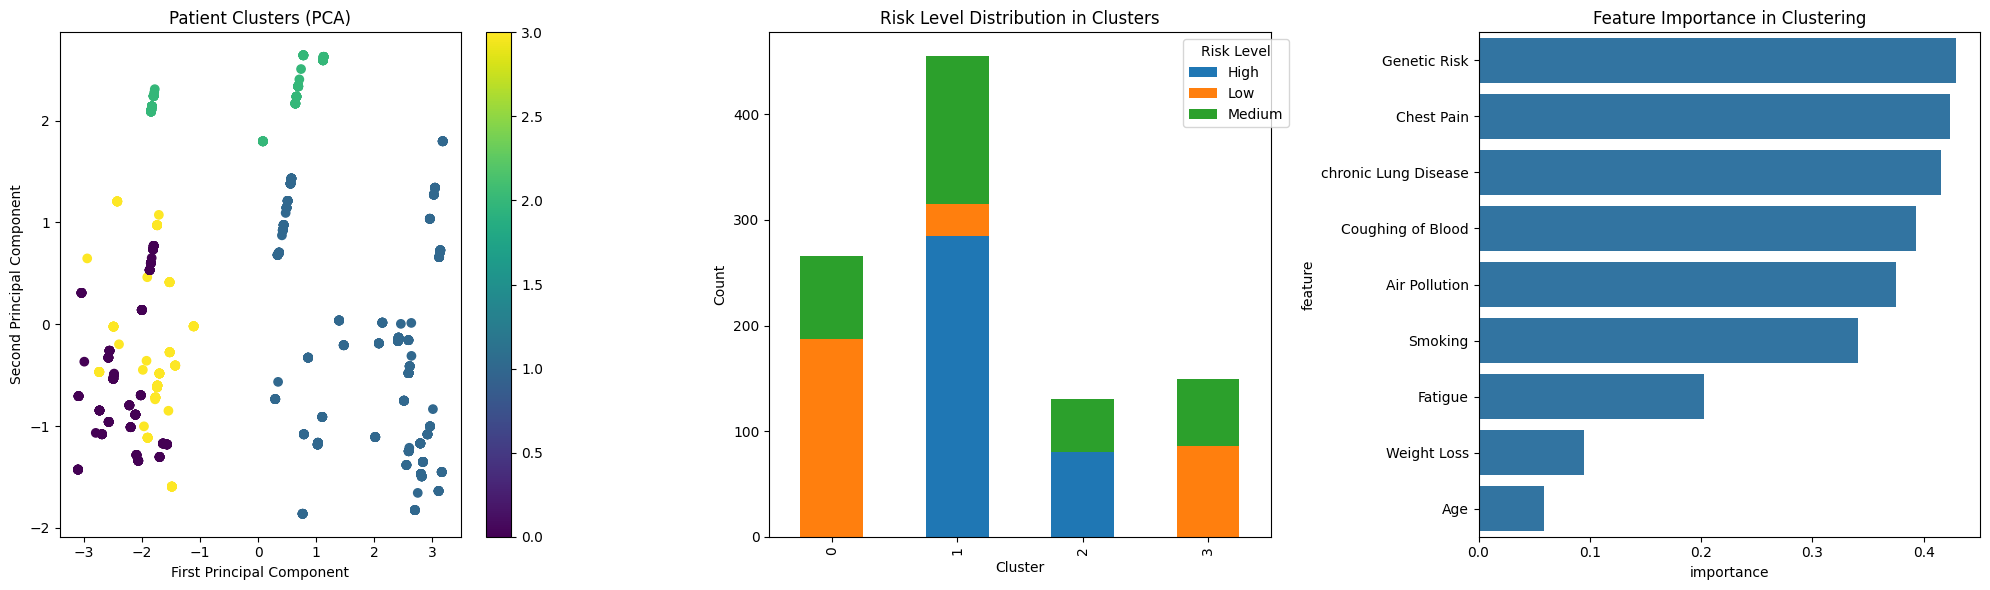


Analyzing cluster characteristics...


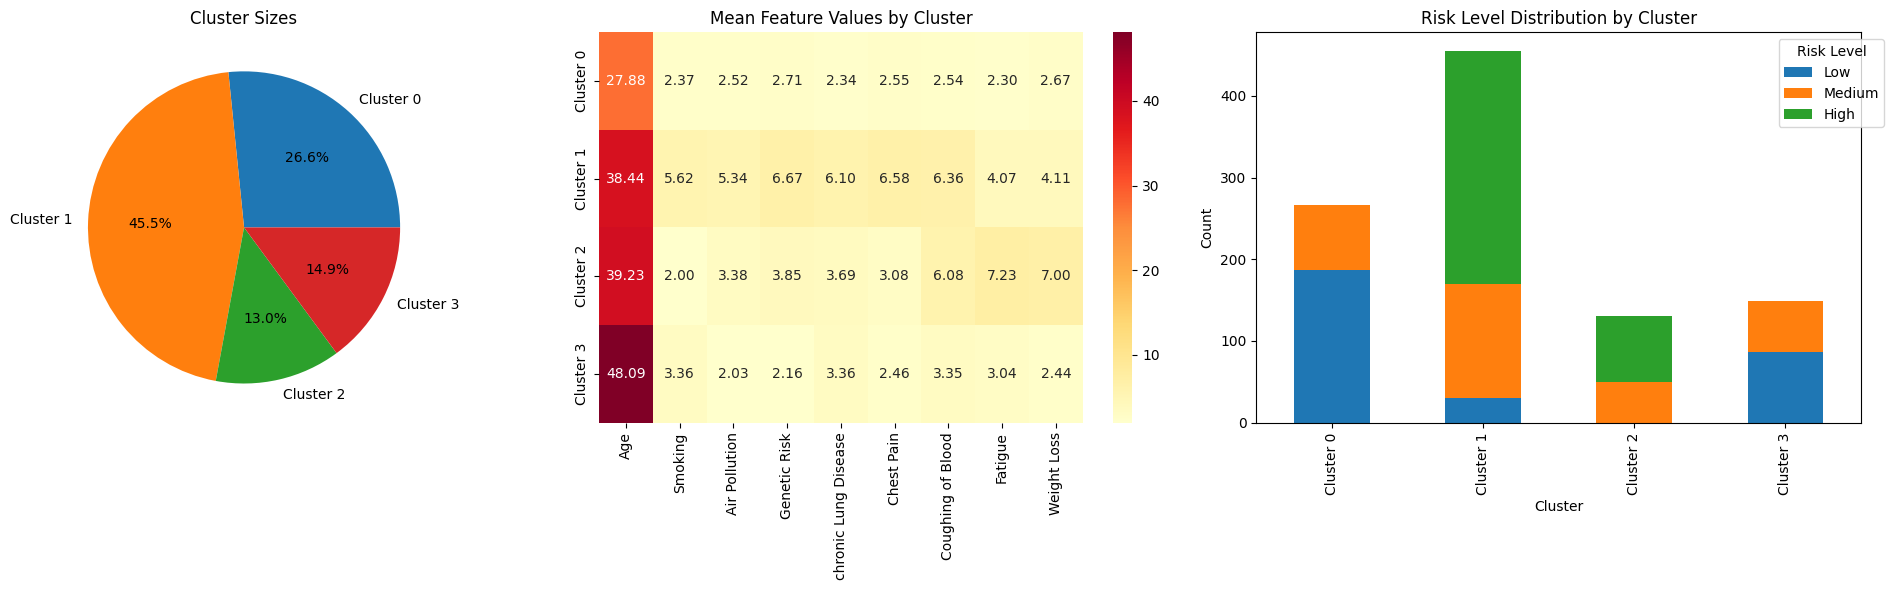


Targeted Interventions by Cluster:

Cluster 0:
Size: 266 patients
Risk Distribution:
  Low: 187
  Medium: 79
Key Risk Factors:
  - Age
Recommended Interventions:

Cluster 1:
Size: 455 patients
Risk Distribution:
  High: 285
  Medium: 140
  Low: 30
Key Risk Factors:
  - Age
Recommended Interventions:

Cluster 2:
Size: 130 patients
Risk Distribution:
  High: 80
  Medium: 50
Key Risk Factors:
  - Age
Recommended Interventions:

Cluster 3:
Size: 149 patients
Risk Distribution:
  Low: 86
  Medium: 63
Key Risk Factors:
  - Age
Recommended Interventions:


In [67]:
analyzer, clusters, interventions = run_clustering_analysis(df)